# Stratospheric Polar Vortex Diagnostics: A Comparison with Hannachi et al. (2011)

This notebook demonstrates the application of the *arctic* Python package to analyze the geometry and dynamics of the stratospheric polar vortex (SPV). It focuses on replicating and extending the methodology from Hannachi et al. (2011) using modern datasets and refined diagnostics.

# Table of Contents
- [Introduction](#introduction)
- [Data](#data)
    - [Differences to Hannachi et al. 2011](#differences-to-hannachi-et-al-2011)
- [Methodology](#methodology)
    - [Reconstruction of same conditions as H11](#reconstruction-of-same-conditions-as-h11)
    - [Scaling](#scaling)
    - [Seasonality](#seasonality)
        - [Durbin Watson Test](#durbin-watson-test)
        - [Autocorrelation Function](#autocorrelation-function)
        - [Singular Spectrum Analysis](#singular-spectrum-analysis)
        - [Extended Empirical Orthogonal Function](#extended-empirical-orthogonal-function)
    - [Gap statistic](#gap-statistic)
    - [Hierarchical clustering](#hierarchical-clustering)
- [Results](#results)
    - [Statistical Profiles of Clusters](#statistical-profiles-of-clusters)
    - [Physical Interpretation and Literature Comparison](#physical-interpretation-and-literature-comparison)
- [Abbreviations](#abbreviations)

# Introduction

## Introduction

The stratospheric polar vortex (SPV) plays a crucial role in modulating mid-latitude winter weather. Disruptions of the SPV — particularly during sudden stratospheric warming (SSW) events — can significantly affect tropospheric circulation patterns, sometimes for weeks.

This notebook replicates and extends the methodology of Hannachi et al. (2011, hereafter H11), who used geometric moments derived from potential vorticity fields to classify vortex morphology. Using the *arctic* Python package, we apply similar diagnostics to ERA5 reanalysis data. The goal is to reproduce their cluster based regime identification and test its robustness using modern, refined diagnostics from geopotential height fields.

# Data
The data used in this study were provided and preprocessed by the Institute of Atmospheric Physics (IAP) in Kühlungsborn. It includes daily diagnostics from ERA5 reanalysis, derived using the IDL-based ELDI and SSW packages. To be concrete, the data include the daily elliptic indices of the stratospheric polar vortex at 10hPa geopotential height and major warming diagnostics.

The data are split into three files:

- `*cen.csv`: Not included in the demo data, but contains event-centered diagnostics, including central SSW dates, i.e. when the wind reversed form westerly to easterly, persistence, maximum eastward wind, intensity, and accumulated intensity.
- `*msw.csv`: Flags daily major warming events with corresponding zonally averaged wind speeds.
- `*d.csv`: Includes daily geometric vortex diagnostics: area, centroid latitude/longitude (latcent, loncent), aspect ratio (ar), orientation angle (theta), and kurtosis. This file also marks split events (S) and includes diagnostics for identified sub-vortices, along with wave diagnostics at 60° latitude.

The ERA5 record spans 1963–2022, but this notebook uses a reduced set covering only the **first 1000 days** (approx. 1963–1971) to mirror the temporal scope in H11. This short duration includes only a few major warmings, limiting the number of split/displacement cases available for clustering.

## Differences to Hannachi et al 2011
H11 used initially the following geometric moments: area, centroid latitude (latcent), aspect ratio (ar), and kurtosis. The latter was omitted due to the dominance of a few outliers. They retrieved the moments from the ERA-40 reanalysis data at 850-K isentropic potential vorticity. In contrast, our data are based on 10hPa geopotential height, using the so called $Z10$ method, from the ERA5 reanalysis data. This methodological difference impacts the classification of vortex events. As Seviour et al. (2013) pointed out, the chosen method for moment calculation can substantially affect the frequency and classification of split vs. displacement events.

One key difference lies in the treatment of **seasonality**. H11 filtered out a ~120-day periodic signal found in the area data. This signal is absent in the ERA5-based geometric moments but reappears in wind speed, which is tied closely to the potential vorticity. To replicate the results from H11 as accurately as possible, the wind speed is included as a proxy for the area used by H11.

In [3]:
# import vortexclust in general
import vortexclust

# import other important libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Import specific functions from arcitc
from vortexclust.io.loader import read_data
from vortexclust.io.cleaner import no_white_space, to_date

# Read data
demo_d = read_data("../data/demo_d.csv")
demo_msw = read_data("../data/demo_msw.csv")

# Remove white space from column names
no_white_space(demo_d)
no_white_space(demo_msw)

# Change string to datetime for better comparison
to_date(demo_d, 'string', format='mixed')
to_date(demo_msw, 'string', format='mixed')

# Merge demo data into one DataFrame
demo_all = demo_d.merge(demo_msw, on ='string', how='left', suffixes=["_d", '_msw'])

# Encode event form labels
from sklearn.preprocessing import LabelEncoder
le_form = LabelEncoder()
demo_all['form'] = le_form.fit_transform(demo_all.form)
print(f"Transformed 'form': \n {le_form.inverse_transform([1])} to 1\n{le_form.inverse_transform([0])} to 0")

# Drop constant columns
demo_all.drop(['D_d', 'D_msw'], axis=1, inplace=True)
# Sort by date
demo_all = demo_all.sort_values('string').reset_index(drop=True)

# Check
demo_all.info()

Using mixed date format might be risky.
Using mixed date format might be risky.
Transformed 'form': 
 ['S'] to 1
['D'] to 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   string    3287 non-null   datetime64[ns]
 1   ar        3287 non-null   float64       
 2   latcent   3287 non-null   float64       
 3   kurtosis  3287 non-null   float64       
 4   area      3287 non-null   float64       
 5   form      3287 non-null   int64         
 6   u         3287 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 179.9 KB


# Methodology
This section reconstructs the analysis framework of Hannachi et al. (2011), adapting it to the ERA5 dataset. We begin by aligning the seasonal and temporal conditions, then scale the data and investigate seasonality using both classical and spectral diagnostics. These steps ensure the data are well-suited for clustering based on vortex geometry.

## Reconstruction of same conditions as H11
H11 focused on winter months (DJFM) across multiple decades. The demo data here covers approximately 1000 days beginning in January 1963. For seasonal consistency, we extract only December–March (DJFM) values.

In the diagrams below a timeseries of the area and wind speed is depicted. They illustrate the consecutive days of DJFM. For a better orientation a second axis with the respective dates is added, though still all other month are skipped. Hence, March is followed by December.

## Scaling
Normalization broadly refers to any generic alteration of data making them more compatible (Gewers et al. 2021). Common approach are *MinMax* scaling, i.e. each feature has a given range $\left[min, max\right]$, or *Standard* scaling as given below, i.e. each variable has a mean of zero and variance of one.

$$x' = \frac{x-\mu}{\sigma}$$

H11 does not explicitly state the applied scaling method. However, based on the timeseries diagrams in their study, Standard scaling appear likely. This is supported by the shape and spread of the rescaled features in the diagrams below.

## Time series of scaled AR, Latcent, Area and kurtosis
Due to the difference in data, the first 1000 days could not be reproduced as in H11. As noted above, the time shift is 516 days, which is illustrated by the dotted line in the diagrams.

It also remains is unclear in which order H11 performed scaling and DJFM selection. Scaling first, then selecting DJFM does result in different values than when proceeding vice versa. For example, when scaling is applied to the full year before selecting DJFM, the "baseline" of area appears to be slightly below zero. Based on visual comparison, it seems that H11 first filtered for DJFM and then scaled.

In [7]:
from sklearn.preprocessing import StandardScaler

# Standardize key variables
sc = StandardScaler()
demo_all = demo_all[demo_all['string'] < '02-05-2006'] # buffer for filtering with eeof: 400days
demo_all.loc[:,['scaled_area', 'scaled_ar', 'scaled_latcent', 'scaled_kurtosis', 'scaled_u']] = sc.fit_transform(demo_all[['area', 'ar', 'latcent', 'kurtosis','u']])

# Filter for DJFM months (H11 seasonality)
demo_winter = demo_all[(demo_all['string'] < '03-15-2006') &
                       demo_all['string'].dt.month.isin([12, 1, 2, 3])]
demo_winter.reset_index(drop=True, inplace=True)

# Keep only relevant variables for clustering
demo = demo_winter[['string', 'area', 'ar', 'latcent', 'kurtosis', 'u']]
# scale on DJFM
demo.loc[:, ['scaled_area', 'scaled_ar', 'scaled_latcent', 'scaled_kurtosis', 'scaled_u']] = sc.fit_transform(demo[['area', 'ar', 'latcent', 'kurtosis', 'u']])

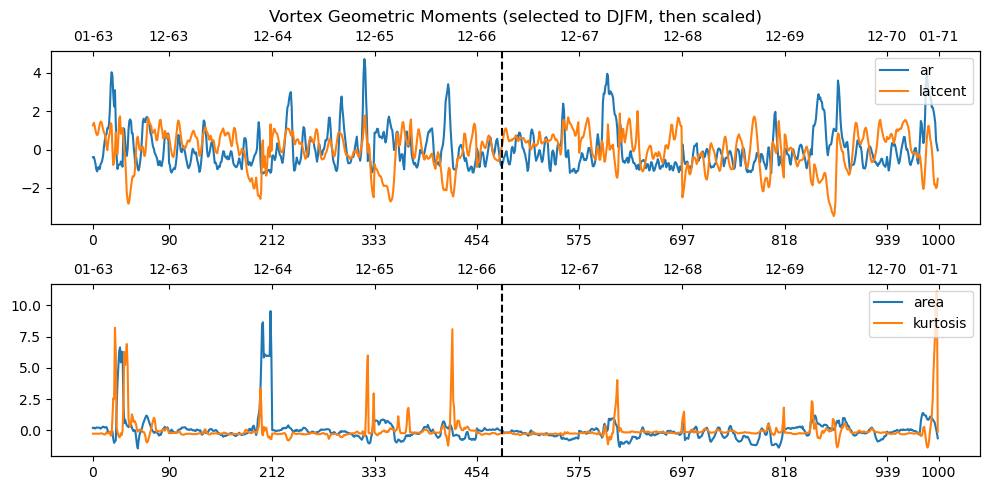

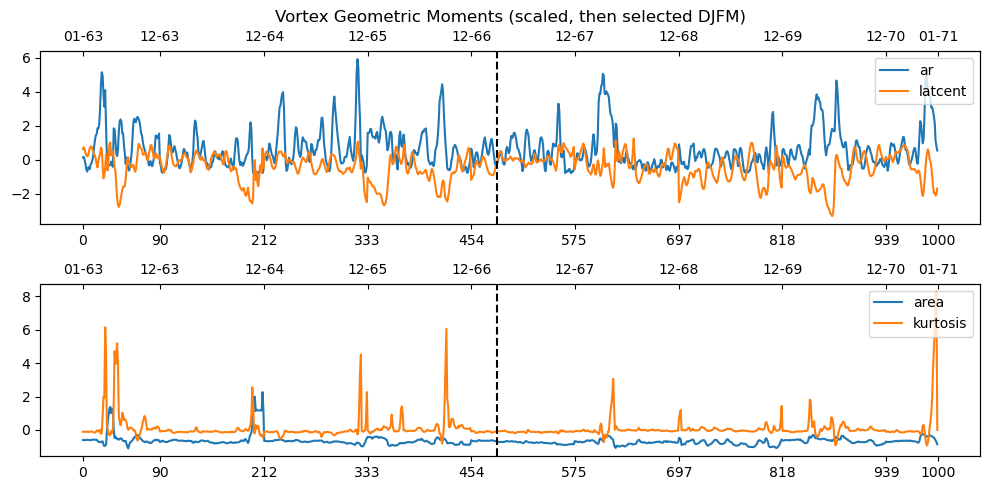

In [8]:
positions = [0]
positions[1: ] = [x for x in range(90, 1000, 121)]
positions[2:] = list(map(lambda x: x+1 , positions[2:]))
positions[6:] = list(map(lambda x: x+1 , positions[6:]))
positions.append(1000)

from vortexclust.workflows.demo import plot_timeseries_moments
plot_timeseries_moments(demo,
                        ['scaled_ar', 'scaled_latcent', 'scaled_area', 'scaled_kurtosis'],
                        ['ar', 'latcent', 'area', 'kurtosis'],
                        title = 'Vortex Geometric Moments (selected to DJFM, then scaled)',
                        time_span=1000,
                        positions=positions,
                        vertical_line=484)

plot_timeseries_moments(demo_winter,
                        ['scaled_ar', 'scaled_latcent', 'scaled_area', 'scaled_kurtosis'],
                        ['ar', 'latcent', 'area', 'kurtosis'],
                        title = 'Vortex Geometric Moments (scaled, then selected DJFM)',
                        time_span=1000,
                        vertical_line=484,
                        positions=positions)

## Seasonality
Seasonality refers to recurring patterns or cycles in the data that occur at regular intervals. In climate data, such patterns are often driven by the solar cycle. For example, the stratospheric vortex builds due to a strong temperature gradient after the autumnal equinox and persists throughout the polar night. As polar day begins and the stratosphere warms, the polar vortex weakens and breaks down.

Neglecting seasonality can bias clustering results by grouping data points based on shared timeing rather than ib underlying physical characteristics. This is particularly problematic for clustering algorithms that are sensitive to the absolute distribution of the data and distances between samples. Removing or accounting for periodic signals ensures that resulting clusters represent true dynamical regimes of the vortex rather than artifacts of seasonality.

### Durbin-Watson Test

The Durbin-Watson test is used to detect the presence of first order autocorrelation in the residuals of a regression model. It assumes that:

- The residuals (errors) are normally distributed with a mean of 0
- The residuals are stationary over time

Commonly, it is interpretated as follows:
- **0 to 1.5**: strong **positive autocorrelation**
- **1.5 to 2.5**: little to **no autocorrelation**
- **2.5 to 4**: strong **negative autocorrelation**

In this analysis, the Durbin-Watson test indicates strong positive autocorrelation in the data, consistent with the findings of H11. This supports the presence of periodic signals in the data.

In [10]:
from statsmodels.stats.stattools import durbin_watson

# Check autocorrelation in scaled area
dw_area = durbin_watson(demo['scaled_area'])
print(f"Durbin-Watson statistic on DJFM, then scaled area: {np.round(dw_area, 3)}")

# Check autocorrelation in scaled zonal wind speed
dw_u = durbin_watson(demo['scaled_u'])
print(f"Durbin-Watson statistic on DJFM, then scaled wind speed: {np.round(dw_u, 3)}")

Durbin-Watson statistic on DJFM, then scaled area: 0.137
Durbin-Watson statistic on DJFM, then scaled wind speed: 0.035


### Autocorrelation function
To further investigate seasonality, the autocorrelation function (ACF) is used. The ACF measures how well a time series correlates with lagged versions of itself. It is defined at lag $k$ as follows

$$\rho_k = \frac{\mathrm{Cov}(x_t, x_{t-k})}{\sigma(x_t) \sigma(x_{t-k})}$$

In this analysis, the ACF is computed on unit vector normalized data. Importantly, scaling does not affect the shape of the autocorrelation, as it is inherently scale-invariant.

The dashed horizontal lines in the plots represent the 5% significance bounds of the ACF. Values of autocorrelation that lie above or below these bounds indicate statistically significant correlation at the corresponding lag.

⚠ For large lag values, ACF computation can become slow. It is recommended to use lags between 500 and 1500.

#### Interpretation
Both features show strong seasonal behaviour over the entire timeseries, which is to be expected from the formation and break down behaviour of the polar vortex.

The wind speed shows persistent periodicity over ~100–150 days, consistent with H11 findings. The area signal also exhibits seasonal behavior, with at least three pronounced peaks above the 5% significance threshold, indicating notable autocorrelation at specific lags.

These diagnostics support the application of deseasonalization techniques, such as SSA or EEOF, to wind speed prior to clustering. For geometric variables like area, no periodicity was found with the autocorrelation function. Hence, no deseasonalization is applied.

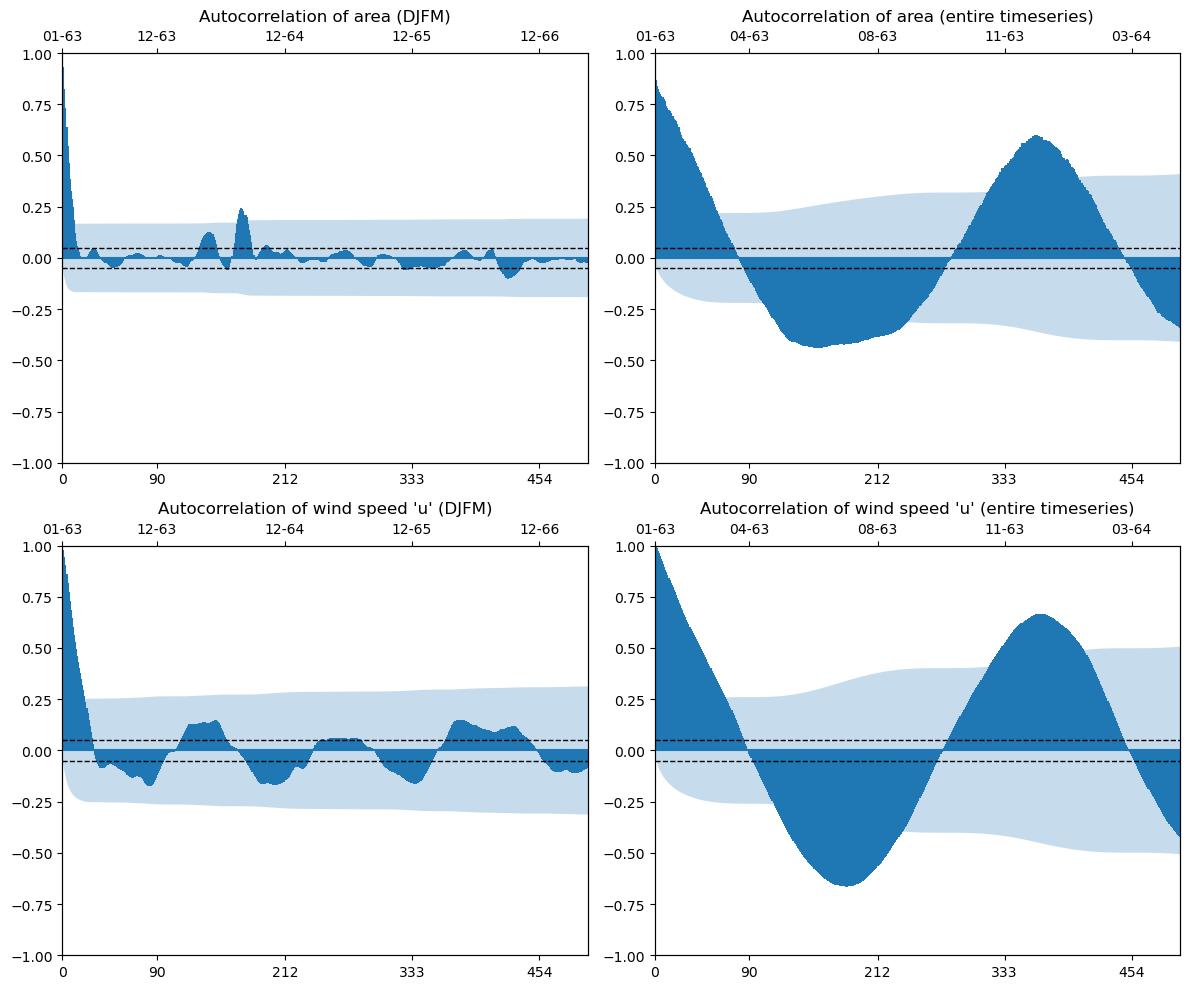

In [11]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(2,2, figsize=(12, 10))
ax = ax.flatten()

plot_acf(demo['scaled_area'], lags=500, ax=ax[0],  marker=None)
plot_acf(demo_all['scaled_area'], lags=500, ax=ax[1], marker=None)

plot_acf(demo['scaled_u'], lags=500, ax=ax[2], marker=None)
plot_acf(demo_all['scaled_u'], lags=500, ax=ax[3], marker = None)

ax[0].set_title('Autocorrelation of area (DJFM)')
ax[1].set_title('Autocorrelation of area (entire timeseries)')
ax[2].set_title("Autocorrelation of wind speed 'u' (DJFM)")
ax[3].set_title("Autocorrelation of wind speed 'u' (entire timeseries)")

for i in range(4):
    # 5% boundaries
    ax[i].axhline(y=0.05, linestyle='--', color='black', linewidth=1)
    ax[i].axhline(y=-0.05, linestyle='--', color='black', linewidth=1)
    # limit at lag
    ax[i].set_xlim(0, 500)
    # reset xticks to 120days period
    ax[i].set_xticks(positions[:5])
    ax[i].set_xticklabels([str(x) for x in positions[:5]])

    # set dates as second axis
    ax_top = ax[i].twiny()
    ax_top.set_xlim(ax[i].get_xlim())
    ax_top.set_xticks(positions[:5])
    if i%2 == 0:
        labels_dt = demo.iloc[positions[:5]]['string'].dt.strftime("%m-%y")
    else:
        labels_dt = demo_all.iloc[positions[:5]]['string'].dt.strftime("%m-%y")
    ax_top.set_xticklabels(labels_dt, ha='center', rotation=0)

plt.tight_layout()
plt.show()

### Singular Spectrum Analysis

Singular Spectrum Analysis (SSA) is a non-parametric spectral decomposition method that can be understood as applying singular value decomposition (SVD) to a lagged embedding of a time series. The original univariate time series is first transformed into a multivariate series via delay embedding, using a sliding window of length $M$.

The choice of window length $M$ is critical: larger values allow for finer decomposition, but for periodic signals, $M$ should not exceed the dominant period to avoid over-smoothing or leakage. Once the embedding is constructed, SVD is applied to extract principal components (eigenvectors) that represent the dominant patterns or oscillatory modes within the time series.

The original signal can then be reconstructed as a sum of selected components, allowing separation of trend, oscillatory, and noise-like behavior.

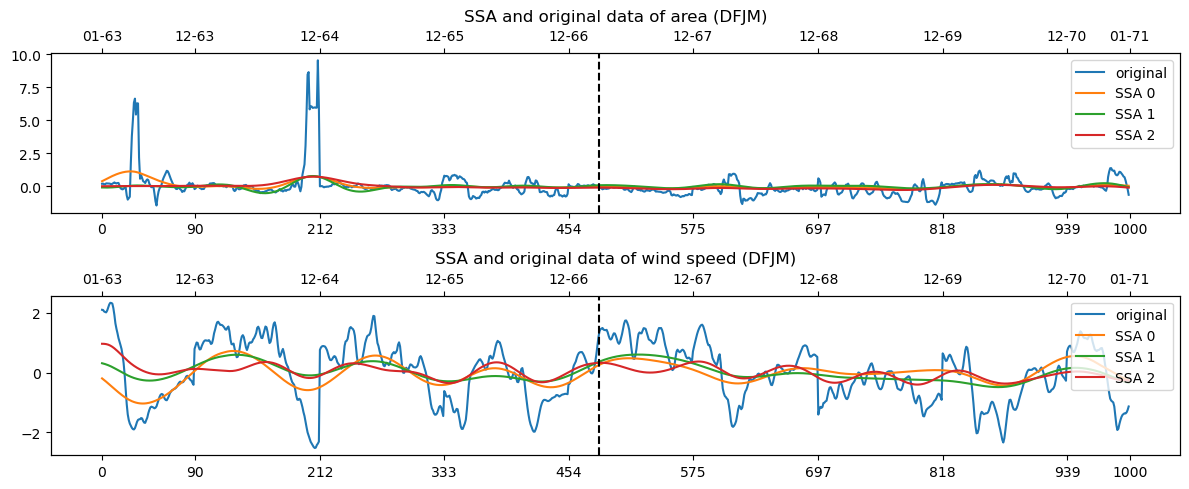

In [12]:
from pyts.decomposition import SingularSpectrumAnalysis

M = 120
ssa = SingularSpectrumAnalysis(window_size=M)
ssa_area = ssa.fit_transform(demo['scaled_area'].values.reshape(1, -1))
ssa_u = ssa.fit_transform(demo['scaled_u'].values.reshape(1, -1))

fig, axes = plt.subplots(2, figsize=(12, 5))
axes[0].set_title('SSA and original data of area (DFJM)')
axes[1].set_title('SSA and original data of wind speed (DFJM)')
axes[0].plot(demo['scaled_area'][:1000], label='original')
axes[1].plot(demo['scaled_u'][:1000], label='original')
for i in range(3):
    axes[0].plot(ssa_area[i, :1000], label=f"SSA {i}")
    axes[1].plot(ssa_u[i, :1000], label=f"SSA {i}")
axes[0].legend(loc='upper right')
axes[1].legend(loc='upper right')
for i in range(2):
    # set dates as second axis
    ax_top = axes[i].twiny()
    ax_top.set_xlim(axes[i].get_xlim())
    ax_top.set_xticks(positions)
    axes[i].set_xticks(positions)
    labels_dt = demo.iloc[positions]['string'].dt.strftime("%m-%y")
    ax_top.set_xticklabels(labels_dt, ha='center', rotation=0)
    axes[i].axvline(x=484, color='black', linestyle='--')

plt.tight_layout()
plt.show()

### Extended Empirical Orthogonal Function
The Extended Empirical Orthogonal Function (EEOF/EOF) is an extension of the standard EOF analysis, adapted for spatiotemporal data. Like SSA, EEOF decomposes time series into orthogonal components, but it does so across multiple correlated variables or spatial locations, incorporating lagged temporal information into each observation vector. This makes EEOF especially well suited for capturing propagating modes and phase relationships between variables.

In the EEOF framework, the data matrix is constructed by stacking lagged versions of each variable (or spatial point), producing a higher-dimensional trajectory matrix. A singular value decomposition (SVD) is then performed to extract the dominant orthogonal modes. These modes can be interpreted as coherent structures in space-time and used for reconstruction, filtering, or dimensionality reduction prior to clustering or regression.

In the implementation below, EEOF decomposition is applied to the scaled DJFM time series of zonal wind speed and vortex area. A lag window of 400 days is selected, which captures multiple full seasonal cycles and is suitable for identifying low-frequency variability. The first 30 principal components are extracted. The explained variance ratio provides insight into the relative importance of each component, while the reconstructed signals can be used for seasonality filtering or further dynamical interpretation. Plotting the EEOF and the Empirical Principle Components (EPCs) over time as well as their phase diagram, gives insight into in the stability of the periodic signal.

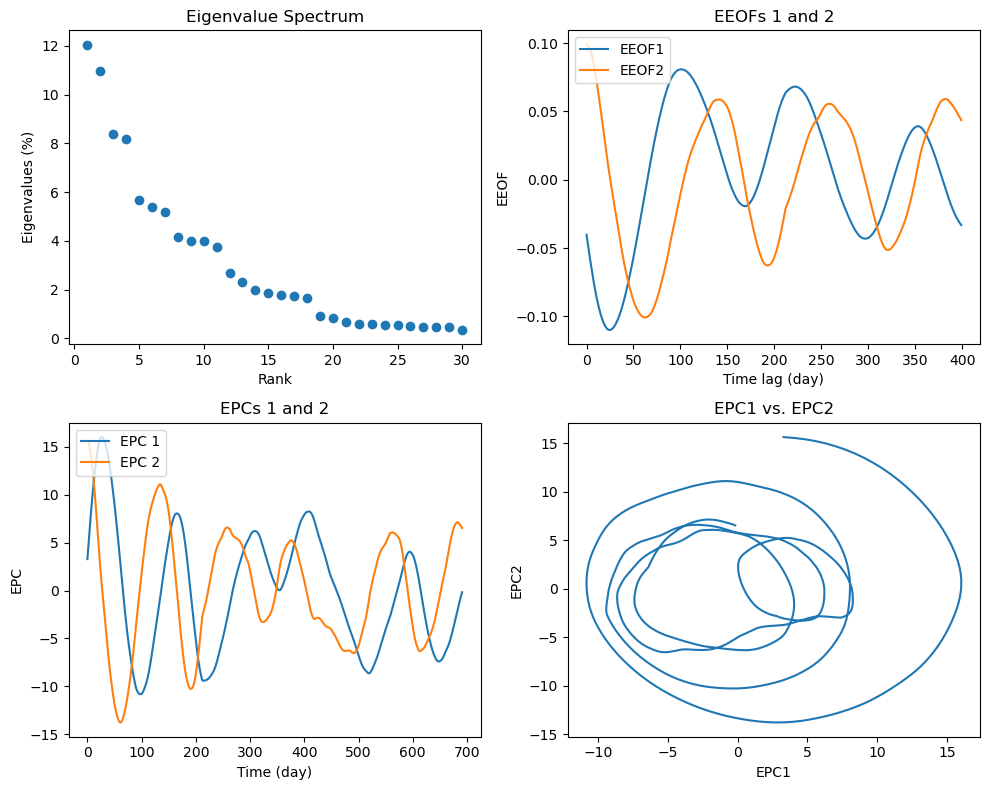

The EEOF evaluation for area based on demo data.


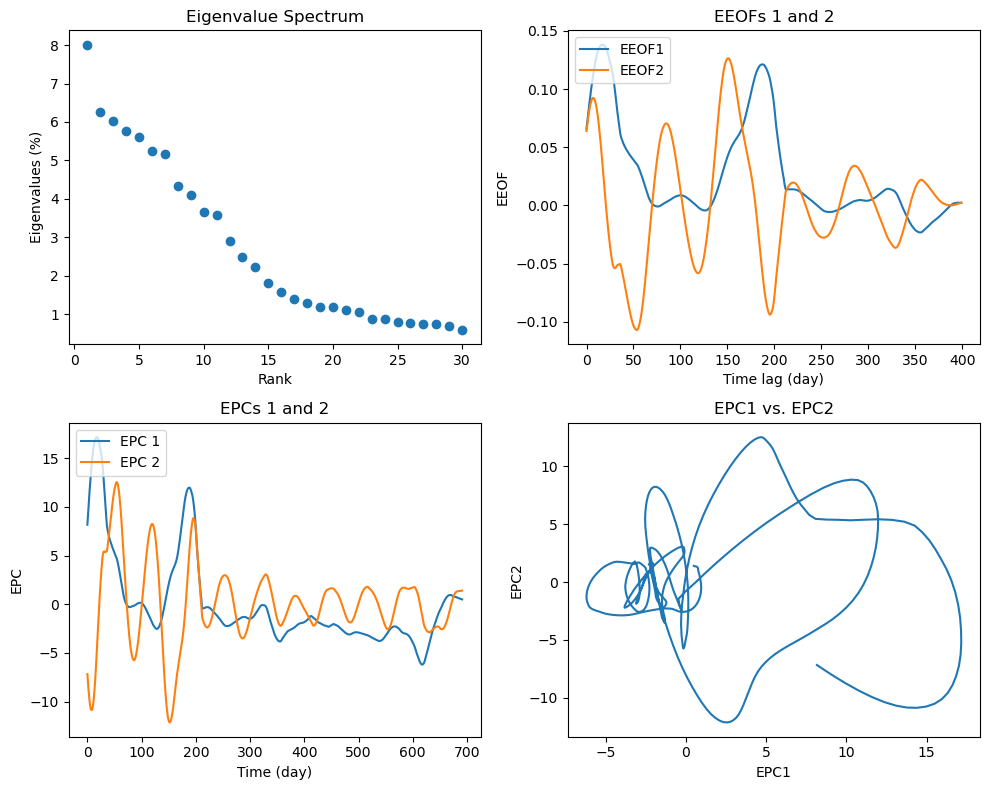

In [13]:
epc_u, eeof_u, expl_var_ratio_u, reconstructed_u, _ = vortexclust.compute_eeof(demo['scaled_u'], M=400, n_components=30)
epc_area, eeof_area, expl_var_ratio_area, reconstructed_area, _ = vortexclust.compute_eeof(demo['scaled_area'], M=400, n_components=30)

from vortexclust.workflows.demo import plot_eeof
plot_eeof(epc_u, eeof_u, expl_var_ratio_u)
print('The EEOF evaluation for area based on demo data.')
plot_eeof(epc_area, eeof_area, expl_var_ratio_area)

### Filtering

To isolate and remove the dominant periodic signal, the time series is reconstructed using a reduced number of components. H11 selected the four leading extended principal components (EPCs) from the EEOF decomposition for this purpose. The reconstructed signal approximates the 120day cycle, which is then subtracted from the original data to yield a deseasonalized time series.

Below, the reconstruction using the four leading EPCs is compared with reconstructions based on SSA components, as well as with reconstructions using 2, 4, and 30 components for both methods. It becomes evident that including too many components leads to near-perfect reconstruction of the original signal. As a result, little to no structure remains in the residual, essentially removing both signal and noise. To avoid this overfitting and to remain consistent with H11, we proceed using the first four components.

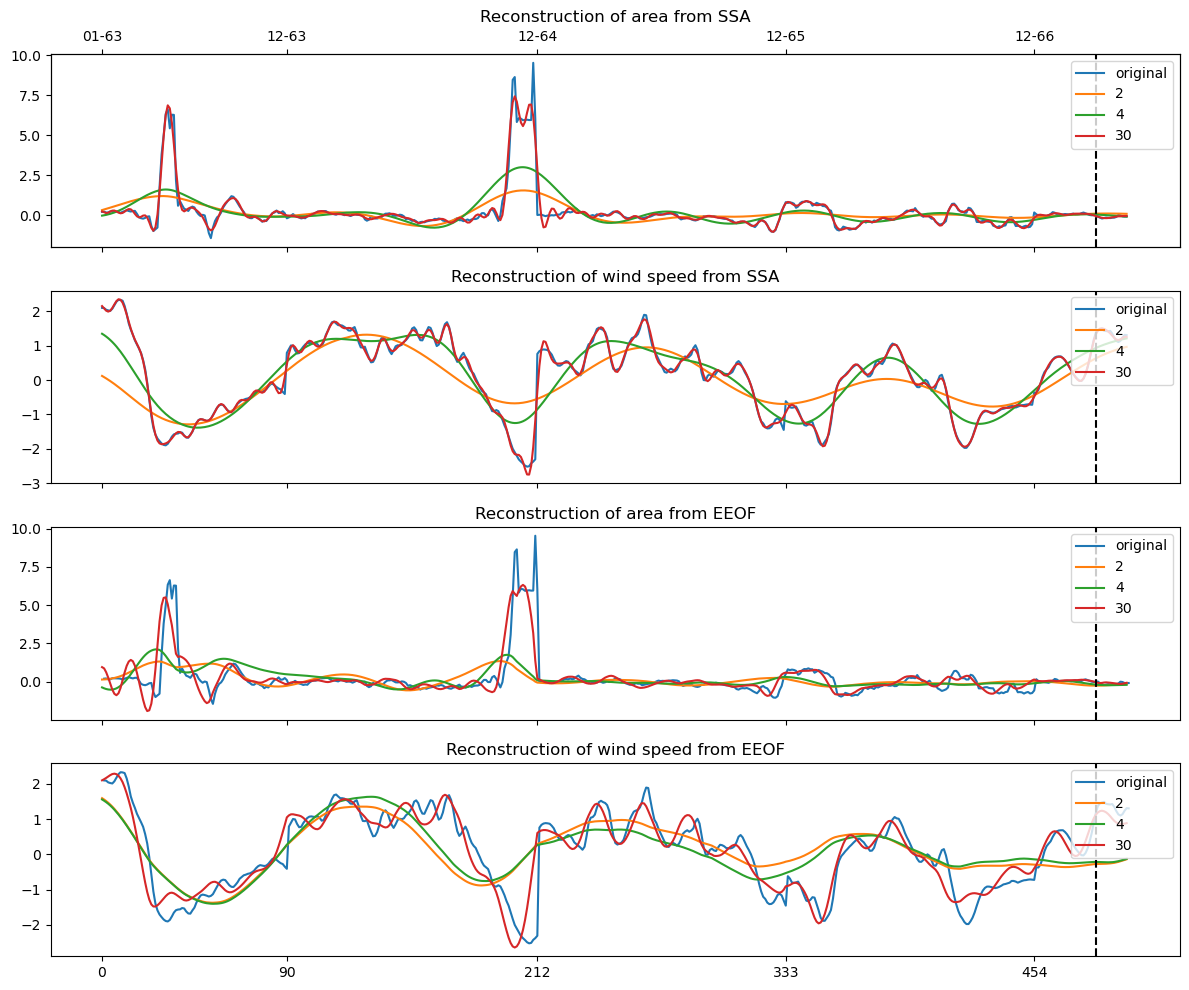

In [14]:
fig, ax = plt.subplots(4, figsize=(12, 10), sharex='all')

ax[0].set_title('Reconstruction of area from SSA')
ax[1].set_title("Reconstruction of wind speed from SSA")
ax[2].set_title('Reconstruction of area from EEOF')
ax[3].set_title("Reconstruction of wind speed from EEOF")

ax[0].plot(demo['scaled_area'][:500], label='original')
ax[1].plot(demo['scaled_u'][:500], label='original')
ax[2].plot(np.arange(1, 501), demo['scaled_area'][:500], label='original')
ax[3].plot(np.arange(1, 501), demo['scaled_u'][:500], label='original')

for idx, i in enumerate([2, 4, 30]):
    ssa_reconstructed_area = ssa_area[:i].sum(axis = 0)
    ssa_reconstructed_u = ssa_u[:i].sum(axis=0)
    _, _, _, eeof_reconstructed_area, _ = vortexclust.compute_eeof(demo['scaled_area'], M=400, n_components=i)
    _, _, _, eeof_reconstructed_u, _ = vortexclust.compute_eeof(demo['scaled_u'], M=400, n_components=i)
    ax[0].plot(ssa_reconstructed_area[:500], label=f"{i}")
    ax[1].plot(ssa_reconstructed_u[:500], label=f"{i}")

    ax[2].plot(eeof_reconstructed_area[399:899, 0], label=f"{i}")
    ax[3].plot(eeof_reconstructed_u[399:899, 0], label=f"{i}")

for i in range(4):
    ax[i].legend(loc='upper right')
    ax[i].axvline(x=484, color='black', linestyle='--')

# set dates as second axis
ax_top = ax[0].twiny()
ax_top.set_xlim(ax[0].get_xlim())
ax_top.set_xticks(positions[:5])
ax[0].set_xticks(positions[:5])
labels_dt = demo.iloc[positions[:5]]['string'].dt.strftime("%m-%y")
ax_top.set_xticklabels(labels_dt, ha='center', rotation=0)
plt.tight_layout()
plt.show()

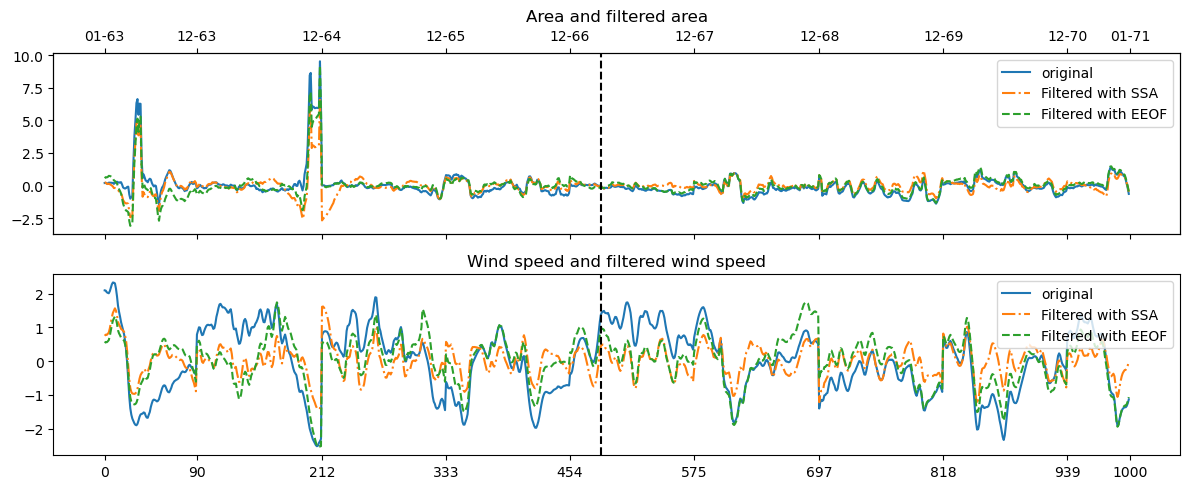

In [15]:
# compute eeof with respective number of components
_, _, _, eeof_reconstructed_area, _ = vortexclust.compute_eeof(demo['scaled_area'], M=400, n_components=4)
_, _, _, eeof_reconstructed_u, _ = vortexclust.compute_eeof(demo['scaled_u'], M=400, n_components=4)

# reduce data to match the time conditions in H11 (1958 to 2002)
demo = demo[demo['string'] < '01-01-2003']

demo['ssa_filtered_area'] = demo['scaled_area'] - ssa_area[:4, :demo.shape[0]].sum(axis = 0).T
demo['ssa_filtered_u'] = demo['scaled_u'] - ssa_u[:4, :demo.shape[0]].sum(axis=0).T

demo.loc[:, 'eeof_filtered_area'] = np.full_like(demo['ssa_filtered_area'], np.nan)
demo.loc[:309, 'eeof_filtered_area'] = demo.loc[:309, 'scaled_area'] - eeof_reconstructed_area[399:709, 0].T
demo.loc[310:1000, 'eeof_filtered_area'] = demo.loc[310:1000, 'scaled_area'].values - eeof_reconstructed_area[399:1090, 309].T
demo.loc[:, 'eeof_filtered_u'] = np.full_like(demo['ssa_filtered_u'], np.nan)
demo.loc[:309, 'eeof_filtered_u'] = demo.loc[:309, 'scaled_u'] - eeof_reconstructed_u[399:709, 0].T
demo.loc[310:1000, 'eeof_filtered_u'] = demo.loc[310:1000, 'scaled_u'] - eeof_reconstructed_u[399:1090, 309]


fig, ax = plt.subplots(2, figsize=(12, 5), sharex='all')
ax[0].set_title('Area and filtered area')
ax[0].plot(demo['scaled_area'][:1000], label='original')
ax[0].plot(demo['ssa_filtered_area'][:1000], '-.', label='Filtered with SSA')
ax[0].plot(demo['eeof_filtered_area'][:1000], '--', label='Filtered with EEOF')
ax[1].set_title('Wind speed and filtered wind speed')
ax[1].plot(demo['scaled_u'][:1000], label='original')
ax[1].plot(demo['ssa_filtered_u'][:1000], '-.', label='Filtered with SSA')
ax[1].plot(demo['eeof_filtered_u'][:1000], '--', label='Filtered with EEOF')

for i in range(2):
    ax[i].legend(loc='upper right')
    ax[i].axvline(x=484, color='black', linestyle='--')
# set dates as second axis
ax_top = ax[0].twiny()
ax_top.set_xlim(ax[0].get_xlim())
ax_top.set_xticks(positions)
ax[0].set_xticks(positions)
labels_dt = demo.iloc[positions]['string'].dt.strftime("%m-%y")
ax_top.set_xticklabels(labels_dt, ha='center', rotation=0)
plt.tight_layout()
plt.show()


## Gap statistic
The performance of clustering algorithm depends severely on the right number of clusters as input. Determining the optimal number of cluster $k_{opt}$ is nontrivial, and fitting models is computationally expensive. Hence, more elegant ways than simply testing different $k$ are required. Further unsupervised clustering has no notion of wrong or right, but requires different measures to evaluate a models quality. Most techniques define a measure of similarity, which should be maximized in clusters and minimized between clusters. Consequently, dissimilarity is defined vice versa. Then the similarity or dissimilarity is compared for different values of $k$.

The gap statistic introduced by Tibshirani et al. (2001) bases on the idea to compare the within cluster dispersion of the actual data to a null reference distribution. The null reference is typically generated by a homogeneous Poisson point process (HPPP).

To compute the within cluster dispersion, the pairwise squared distances between all data points in a cluster $C_m, m=1, ..., k$ are computed by

$$D_m = \sum_{i,j \in C_m} \|x_i- x_j\|^2 = 2n_m \sum_{i=1}^{n_m} \|x_i- \mu_m\|^2$$

with $|C_m| = n_m$ being the size of the $m$th cluster. Note that this assumes Euclidean geometry and unweighted samples.

Some implementations use the distance $\|x_i - c_m\|$, i.e. the distance of a data point $x_i$ to its corresponding cluster center $c_m=\mu_m$. This is only applicable in clustering algorithms that have some notion of centers such as k-means. For clustering methods without such centers, such as hierarchical clustering, the gap statistic is more precise using the above notation instead of calculating centers manually.

In the next step, $D_m$ is averaged to obtain the overall dispersion index $W_k$.
$$W_k = \sum_{m=1}^{k} \frac{D_m}{2n_m}$$
The sum of squared distances to the center of a cluster is the same as $W_k$ as long there are no sample weights.

Finally, the gap statistic for each $k$ is computed by the difference between the *within dispersion index* of the data, $log(W_k)$,  and that expected from the generated reference $log(W_k^*)$.
$$G(k) = E[log(W_k^*)] - log(W_k)$$

Here, $E(\cdot)$ is the expectation as usually defined. A Monte Carlo simulation generates $N$ samples of $log(W_k^*)$, where each $W_k^*$ is based on the same number of points as the original data. Additionally, the standard deviation $s_k^*$ is computed and used to account for the simulation error in $E[log(W_k^*)]$ with the inflated standard deviation $s_k = s_k^*\sqrt{1+\frac{1}{N}}$. Finally, the optimal $k_{opt}$ is determined by the smallest $k$ such that

$$
	G(k) \geq G(k+1) - s_{k+1}
$$

Tibshirani et al. demonstrated that the gap statistic is a robust method for estimating the number of clusters. Their findings indicate that, for elongated clusters, the gap statistic yields better results with a null reference aligned to the data's principal components. In contrast, using a simple uniform distribution leads to inferior results. Overall, the underlying distribution of data does not influence the results of the gap statistic, making it more robust than other methods.

The performance of the gap statistic deteriorates in high-dimensional settings due to computational costs. It is also prone to underestimation the optimal $k$ in settings with many clusters. The underestimation vanishes with increasing dimensionality.

H11 focused primarily on the gap statistic. In the analysis below, it is applied alongside the **elbow** and **silhouette** methods for comparison.

## Hierarchical Clustering
Hierarchical clustering is a family of clustering methods that focuses on building nested clusters. This is achieved by merging or splitting them successively. The hierarchy can be represented in a so-called dendrogram, i.e. a tree, where the root contains all samples and each leaf represents a samples. Leaves next to each other correspond to similar samples. H11 does not specify the precise algorithm, so agglomorative clustering is applied here as an adaption.

Agglomerative clustering uses a bottom up approach, i.e. each sample starts as its own cluster and is successively merged with the nearest cluster. The mergingn criterion is defined by a linkage method, which determines how distances between clusters are computed. The default is $complete$ as determined in H11 to prevent spheroidal or elongated (chained) clusters and distance means the Euclidean distance. Below an overview of some linkage methods is given.

|               | between points in Cluster | to different clusters                      |
|---------------|---------------------------|--------------------------------------------|
| Closest       | Single Linkage            | Centroid Linkage                           |
| Most Distance | **Complete Linkage**      | Average Linkage (Average of all distances) |

Due to the computational intensity of model fitting and validation, the following code cells may require several minutes to complete.

In [16]:
k_max = 10
gap_ar_latcent = vortexclust.gap_statistic(demo[['scaled_ar', 'scaled_latcent']], k_max=k_max, n_replicates=15)
gap_ar_latcent_area = vortexclust.gap_statistic(demo[['scaled_ar', 'scaled_latcent', 'scaled_area']], k_max=k_max, n_replicates=15)
gap_ar_latcent_filteredssa = vortexclust.gap_statistic(demo[['scaled_ar', 'scaled_latcent', 'ssa_filtered_area']], k_max=k_max, n_replicates=15)
gap_ar_latcent_u = vortexclust.gap_statistic(demo[['scaled_ar', 'scaled_latcent', 'ssa_filtered_u']], k_max=k_max, n_replicates=15)

In [17]:
k_max = 10
gap_ar_latcent = vortexclust.gap_statistic(demo[['scaled_ar', 'scaled_latcent']], k_max=k_max, n_replicates=15)
gap_ar_latcent_area = vortexclust.gap_statistic(demo[['scaled_ar', 'scaled_latcent', 'scaled_area']], k_max=k_max, n_replicates=15)
gap_ar_latcent_filteredssa = vortexclust.gap_statistic(demo[['scaled_ar', 'scaled_latcent', 'ssa_filtered_area']], k_max=k_max, n_replicates=15)
gap_ar_latcent_u = vortexclust.gap_statistic(demo[['scaled_ar', 'scaled_latcent', 'ssa_filtered_u']], k_max=k_max, n_replicates=15)

In [18]:
elbow_ar_latcent = vortexclust.elbow_method(demo[['scaled_ar', 'scaled_latcent']], k_max=k_max)
elbow_ar_latcent_area = vortexclust.elbow_method(demo[['scaled_ar', 'scaled_latcent', 'scaled_area']], k_max=k_max)
elbow_ar_latcent_filteredssa = vortexclust.elbow_method(demo[['scaled_ar', 'scaled_latcent', 'ssa_filtered_area']], k_max=k_max)
elbow_ar_latcent_u = vortexclust.elbow_method(demo[['scaled_ar', 'scaled_latcent', 'ssa_filtered_u']], k_max=k_max)

In [19]:
silhouette_ar_latcent = vortexclust.silhouette_method(demo[['scaled_ar', 'scaled_latcent']], k_max=k_max)
silhouette_ar_latcent_area = vortexclust.silhouette_method(demo[['scaled_ar', 'scaled_latcent', 'scaled_area']], k_max=k_max)
silhouette_ar_latcent_filteredssa = vortexclust.silhouette_method(demo[['scaled_ar', 'scaled_latcent', 'ssa_filtered_area']], k_max=k_max)
silhouette_ar_latcent_u = vortexclust.silhouette_method(demo[['scaled_ar', 'scaled_latcent', 'ssa_filtered_u']], k_max=k_max)

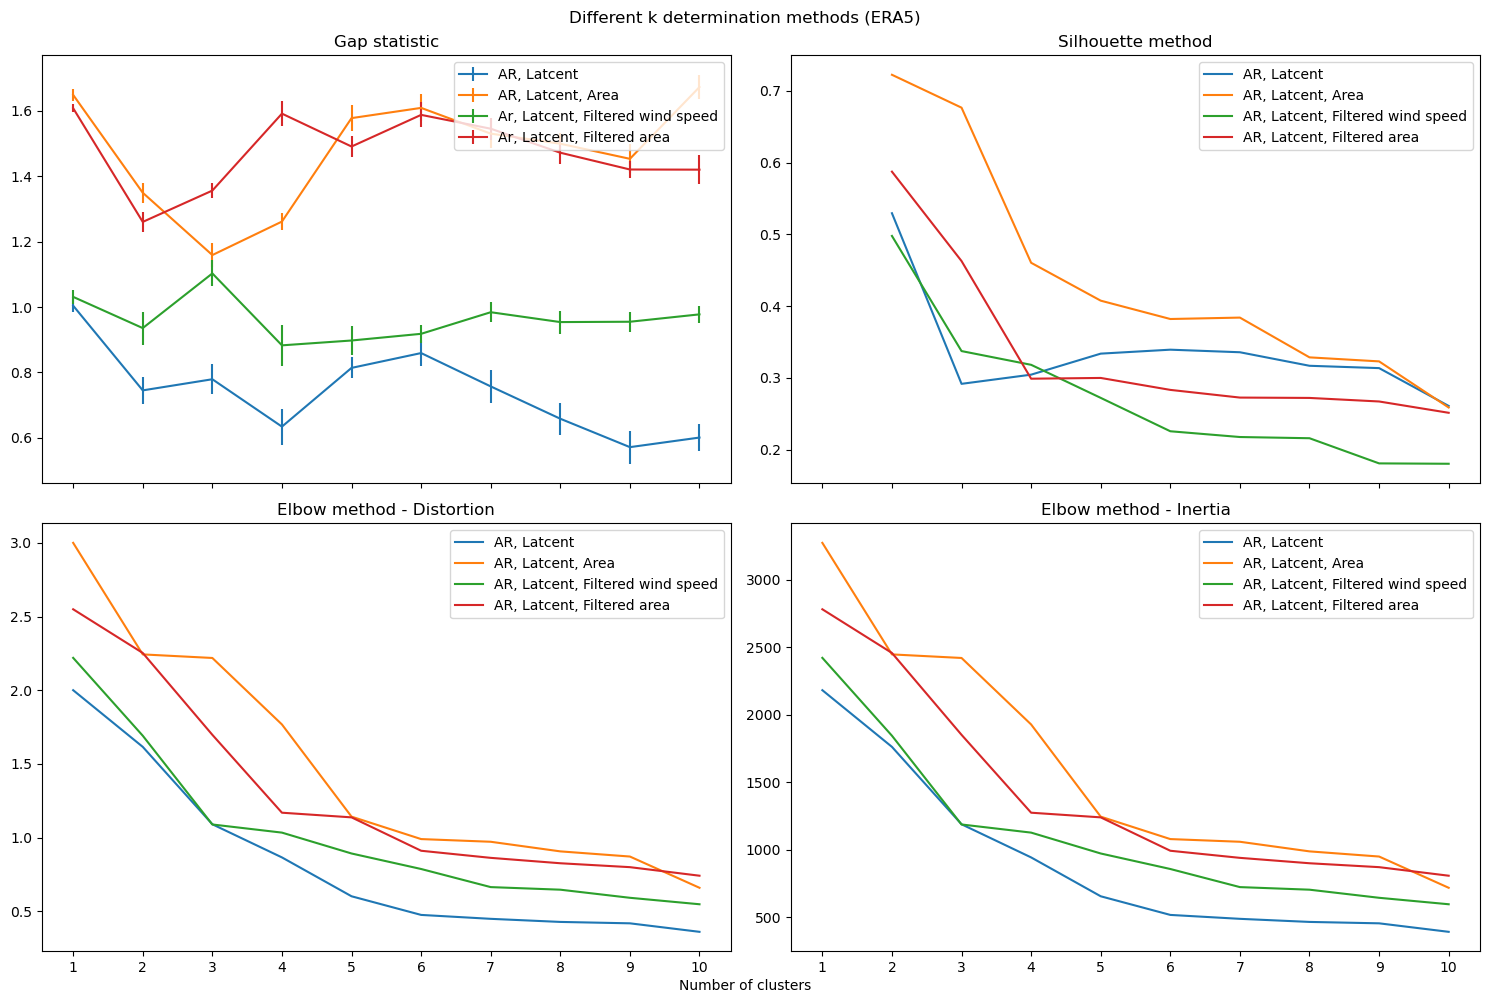

In [20]:
fig, ax = plt.subplots(2,2, figsize=(15, 10), sharex='all')
ax[0][0].errorbar(np.arange(1,k_max+1), gap_ar_latcent[:, 0], yerr=gap_ar_latcent[:, 1], label='AR, Latcent')
ax[0][0].errorbar(np.arange(1,k_max+1), gap_ar_latcent_area[:, 0], yerr=gap_ar_latcent_area[:, 1], label='AR, Latcent, Area')
ax[0][0].errorbar(np.arange(1,k_max+1), gap_ar_latcent_u[:, 0], yerr=gap_ar_latcent_u[:, 1], label='Ar, Latcent, Filtered wind speed')
ax[0][0].errorbar(np.arange(1,k_max+1), gap_ar_latcent_filteredssa[:, 0], yerr=gap_ar_latcent_filteredssa[:, 1], label='Ar, Latcent, Filtered area')
ax[0][0].set_title('Gap statistic')
ax[0][0].legend(loc='upper right')

ax[1][0].plot(np.arange(1,k_max+1), elbow_ar_latcent[0], label='AR, Latcent')
ax[1][0].plot(np.arange(1,k_max+1), elbow_ar_latcent_area[0], label='AR, Latcent, Area')
ax[1][0].plot(np.arange(1,k_max+1), elbow_ar_latcent_u[0], label='AR, Latcent, Filtered wind speed')
ax[1][0].plot(np.arange(1,k_max+1), elbow_ar_latcent_filteredssa[0], label='AR, Latcent, Filtered area')
ax[1][0].set_title('Elbow method - Distortion')
ax[1][0].legend(loc='upper right')

ax[1][1].plot(np.arange(1,k_max+1), elbow_ar_latcent[1], label='AR, Latcent')
ax[1][1].plot(np.arange(1,k_max+1), elbow_ar_latcent_area[1], label='AR, Latcent, Area')
ax[1][1].plot(np.arange(1,k_max+1), elbow_ar_latcent_u[1], label='AR, Latcent, Filtered wind speed')
ax[1][1].plot(np.arange(1,k_max+1), elbow_ar_latcent_filteredssa[1], label='AR, Latcent, Filtered area')
ax[1][1].set_title('Elbow method - Inertia')
ax[1][1].legend(loc='upper right')

ax[0][1].plot(np.arange(2,k_max+1), silhouette_ar_latcent, label='AR, Latcent')
ax[0][1].plot(np.arange(2,k_max+1), silhouette_ar_latcent_area, label='AR, Latcent, Area')
ax[0][1].plot(np.arange(2,k_max+1), silhouette_ar_latcent_u, label='AR, Latcent, Filtered wind speed')
ax[0][1].plot(np.arange(2,k_max+1), silhouette_ar_latcent_filteredssa, label='AR, Latcent, Filtered area')
ax[0][1].set_title('Silhouette method')
ax[0][1].legend(loc='upper right')

plt.suptitle('Different k determination methods (ERA5)')
plt.xticks(np.arange(1, k_max+1))
fig.text(0.5, 0, 'Number of clusters', ha='center')
plt.tight_layout()
plt.show()

In [21]:
print("Optimal number of clusters by each method: ")
p_1, p_2, p_3, p_4 = 1,1,1,1
for k in range(1, 10):
    if p_1 and (gap_ar_latcent[k][0] >= gap_ar_latcent[k+1][0] - gap_ar_latcent[k+1][1]):
        print('Gap statistic (AR, Latcent): ', k+1) # index starts at 0, k starts at 1
        p_1=0
    if p_2 and (gap_ar_latcent_area[k][0] >= gap_ar_latcent_area[k+1][0] - gap_ar_latcent_area[k+1][1]):
        print("Gap statistic (AR, Latcent, Area): ", k+1)
        p_2 = 0
    if p_4 and (gap_ar_latcent_filteredssa[k][0] >= gap_ar_latcent_filteredssa[k+1][0] - gap_ar_latcent_filteredssa[k+1][1]):
        print("Gap statistic (AR, Latcent, SSA filtered Area): ", k+1)
        p_4 = 0
    if p_3 and (gap_ar_latcent_u[k][0] >= gap_ar_latcent_u[k+1][0] - gap_ar_latcent_u[k+1][1]):
        print("Gap statistic (AR, Latcent, filtered wind speed): ", k+1)
        p_3=0

print("Silhouette method (AR, Latcent): ", pd.DataFrame(silhouette_ar_latcent).idxmax()[0]+2)
print("Silhouette method (AR, latcent, Area): ", pd.DataFrame(silhouette_ar_latcent_area).idxmax()[0]+2)
print("Silhouette method (AR, latcent, filtered Area): ", pd.DataFrame(silhouette_ar_latcent_filteredssa).idxmax()[0]+2)
print("Silhouette method (AR, latcent, filtered wind speed): ", pd.DataFrame(silhouette_ar_latcent_u).idxmax()[0]+2)

Optimal number of clusters by each method: 
Gap statistic (AR, Latcent):  2
Gap statistic (AR, Latcent, Area):  2
Gap statistic (AR, Latcent, filtered wind speed):  3
Gap statistic (AR, Latcent, SSA filtered Area):  4
Silhouette method (AR, Latcent):  2
Silhouette method (AR, latcent, Area):  2
Silhouette method (AR, latcent, filtered Area):  2
Silhouette method (AR, latcent, filtered wind speed):  2


### Optimal number of clusters
The gap statistic mainly suggest that the data lacks inherent clustering structure, consistently favouring $k=1$. The silhouette method supports that. And the results align with the findings from the full analysis.

However, when assuming that at least some structure exists and evaluating $k > 1$, most methods indicate $k_{opt} = 3$ when clustering based on ar and latcent, or ar, latcent and the filtered wind speed. The wind speed acts as a proxy for the behaviour of the area as used in H11.

In contrast, the introduction of the area computed from $Z10$ leads to ambiguity. The gap statistic and silhouette method indicate no structure in the data. Though the gap statistic has local maxima at $k=4$ and $k=6$. And another at $k=7$ when the area is filtered. It is a known disadvantage of the gap statistic, that it selects the first local maxima as optimal $k$, even though another $k$ might be more suitable. The silhouette method has sharp breaks at $k=3$ and $k=4$ indicating possible values. A similar behaviour can be observed with the elbow method.

Tabular summary of $k_o{opt}$ for each method:

| Used features              | Gap statistic | Silhouette | Elbow (Distortion) | Elbow (Inertia) |
|----------------------------|---------------|------------|--------------------|-----------------|
| AR, latcent                | 1 or 3 or 6   | 2 or 3     | 3 or 5             | 3 or 5          |
| AR, latcent, wind speed    | 3             | 2 or 3     | 3                  | 3               |
| AR, latcent, area          | 1 or 6 or 10  | 2 or 4     | 2 or 5             | 2 or 5          |
| AR, latcent, filtered area | 1 or 4        | 2 or 4     | 4 or 6             | 4 or 6          |


For the remainder of the analysis $k_{opt} = 3$ is adopted, based on convergence of the elbow method, gap statistic and silhouette method for clustering based on ar, latcent and wind speed. Further this aligns with the results found in the extended analysis on the full data set.

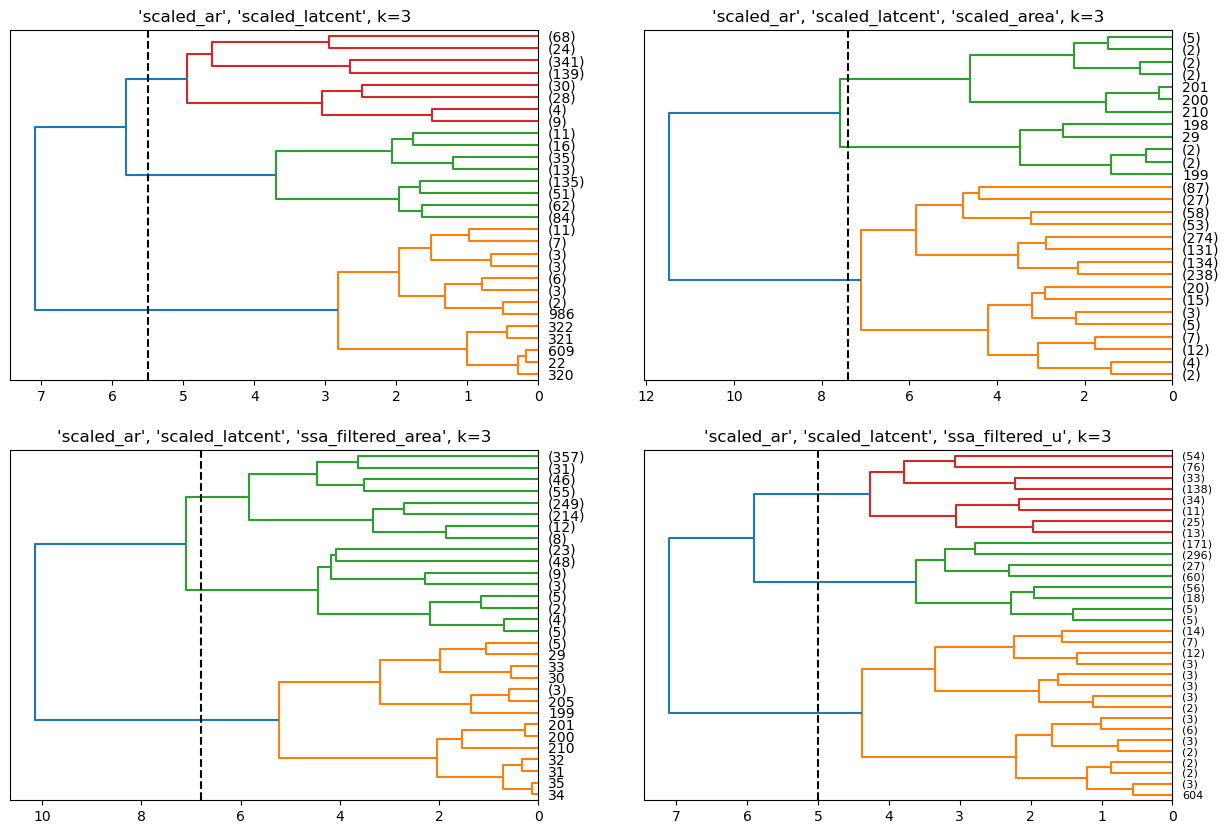

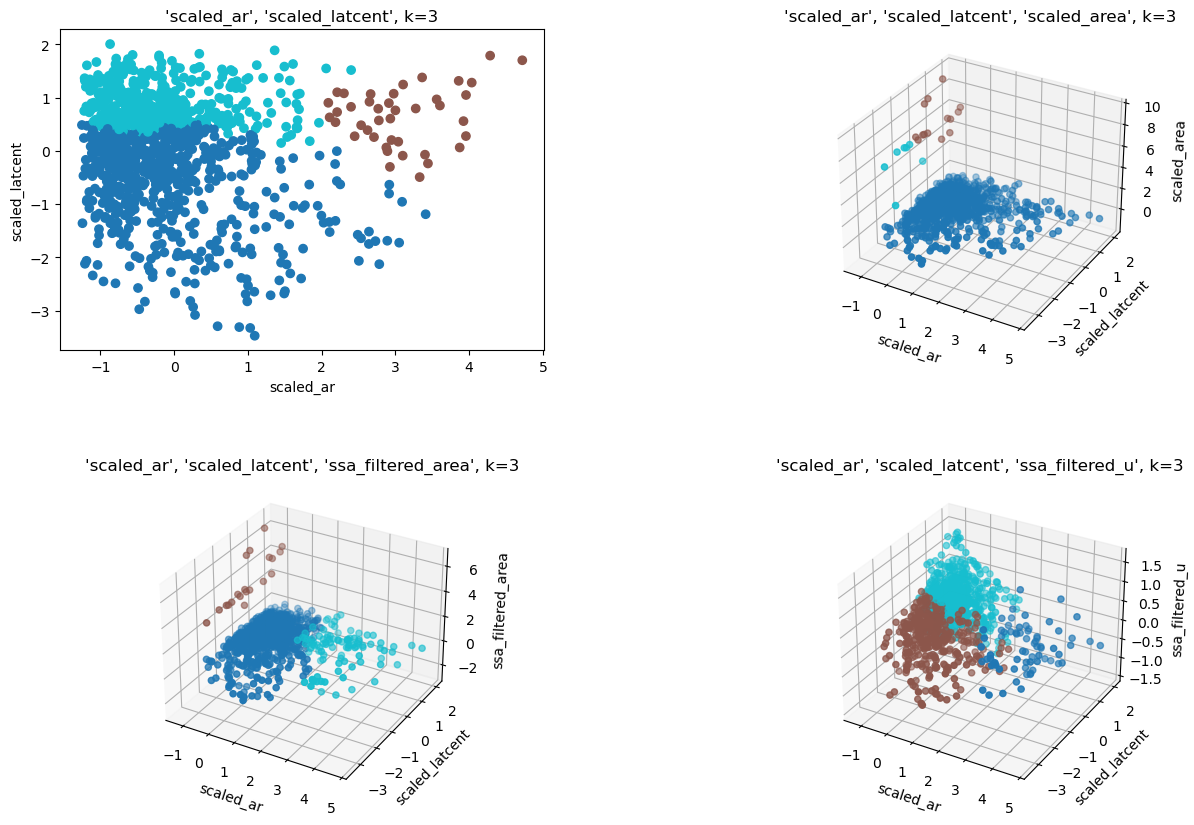

In [22]:
from sklearn import clone
from sklearn.cluster import AgglomerativeClustering

features_kopt = [{'features' : ['scaled_ar', 'scaled_latcent'], 'k_opt' : 3, 'line':5.5},
                 {'features' : ['scaled_ar', 'scaled_latcent', 'scaled_area'], 'k_opt' : 3, 'line':7.4},
                 {'features' : ['scaled_ar', 'scaled_latcent', 'ssa_filtered_area'], 'k_opt' : 3, 'line':6.8},
                 {'features' : ['scaled_ar', 'scaled_latcent', 'ssa_filtered_u'], 'k_opt' : 3, 'line':5}]


Y = []
base_model = AgglomerativeClustering(linkage='complete', compute_distances=True)

fig = plt.figure(figsize=(15,10))
for idx, feat_k in enumerate(features_kopt):
    model = clone(base_model)
    model.set_params(n_clusters = feat_k['k_opt'])
    model.fit(demo[feat_k['features']])
    ax = fig.add_subplot(2,2,idx+1)
    ax.set_title(str(feat_k['features'])[1:-1]+", k="+str(feat_k['k_opt']))
    vortexclust.plot_dendrogram(model, truncate_mode='level', p=4, direction='LR')
    ax.axvline(feat_k['line'], ls='--', color='black')
    y_pred = model.labels_.astype(int)
    Y.append(y_pred)
plt.show()

fig = plt.figure(figsize=(15,10))
for idx, feat_k in enumerate(features_kopt):
    if len(feat_k['features']) == 3:
        ax = fig.add_subplot(2,2,idx+1, projection='3d')
        ax.scatter(demo[feat_k['features']].iloc[:, 0],
                   demo[feat_k['features']].iloc[:, 1],
                   demo[feat_k['features']].iloc[:, 2],
                   c=Y[idx], cmap='tab10')
        ax.set_facecolor((0, 0, 0, 0))
        ax.set_xlabel(feat_k['features'][0])
        ax.set_ylabel(feat_k['features'][1])
        ax.set_zlabel(feat_k['features'][2])
    else:
        ax = fig.add_subplot(2,2, idx+1)
        ax.scatter(demo[feat_k['features']].iloc[:, 0],
                   demo[feat_k['features']].iloc[:, 1],
                   c=Y[idx], cmap='tab10')
        ax.set_xlabel(feat_k['features'][0])
        ax.set_ylabel(feat_k['features'][1])
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    ax.set_title(str(feat_k['features'])[1:-1]+", k="+str(feat_k['k_opt']))
plt.show()

# Results
Below the relative and absolute distribution of physical measurements are visualized for each cluster. The goal is to identify and assign clear characteristics for each cluster. In particular, the following is expected:
- A split cluster (S) that corresponds to the threshold based assignment of split,
- A displaced cluster (D) characterized by notably low centroid latitude,
- A normal or undisturbed cluster (U) without strong anomalies.
Note that split events are usually accompanied by displacement.

## Statistical Profiles of Clusters
### Aspect ratio and Latcent
The majority of samples fall into Class **2**, which exhibits no strong geometric extremes and likely corresponds to the undisturbed state.
- Class **1** displays consistently elevated aspect ratios, indicating highly elongated or split vortices.
- Class **0** shows significantly lower centroid latitudes

Based on these profiles, clusters are assigned as follows:

**0** &rarr; D (Displaced)<br>
**1** &rarr; S (Split)<br>
**2** &rarr; U (Undisturbed/normale state)

Averages per class and features:
              scaled_ar  scaled_latcent
y_ar_latcent                           
D             -0.101076       -0.612666
S              3.071853        0.644008
U             -0.149764        0.903047
y_ar_latcent
D    643
U    407
S     41
Name: count, dtype: int64


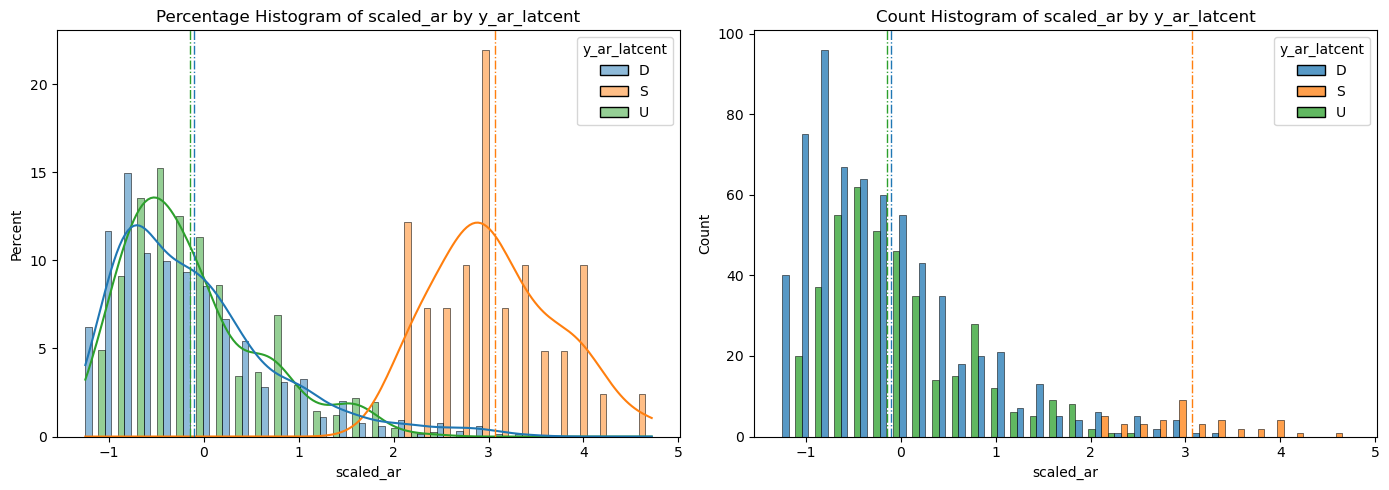

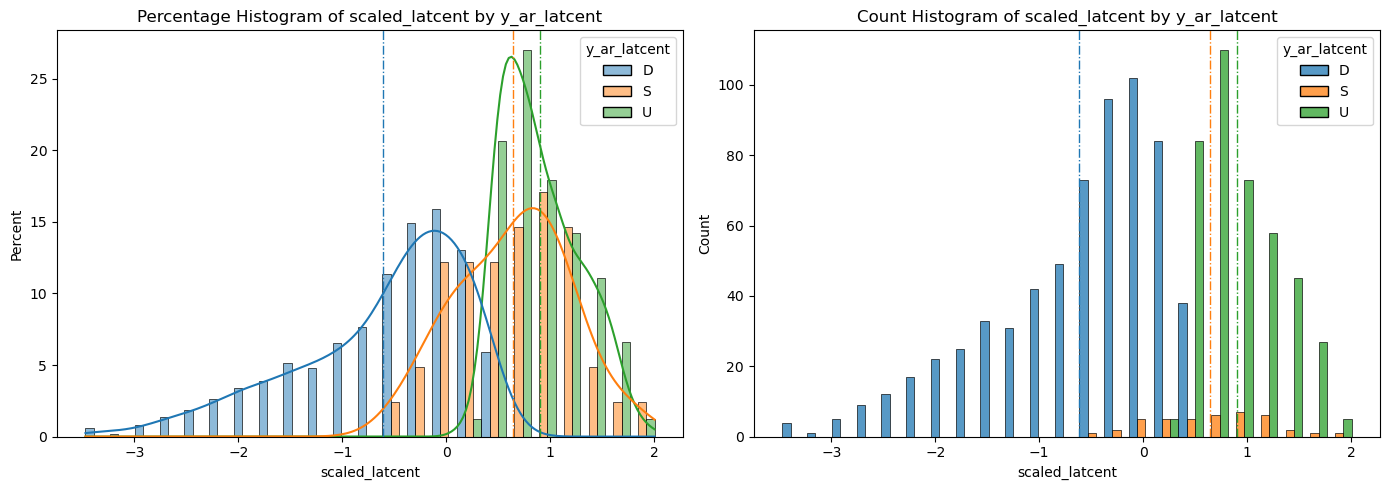

In [24]:
from vortexclust.workflows.demo import plot_hist_per_class

y_names = ['y_ar_latcent', 'y_ar_latcent_scArea', 'y_ar_latcent_filteredArea', 'y_ar_latcent_u']
demo[y_names] = pd.DataFrame(Y).T

demo['y_ar_latcent'] = demo['y_ar_latcent'].replace({0: 'D', 1:'S', 2:'U'})
print("Averages per class and features:")
print(demo[['y_ar_latcent', 'scaled_ar', 'scaled_latcent']].groupby(['y_ar_latcent']).mean())
print(demo['y_ar_latcent'].value_counts())

plot_hist_per_class(demo, # data
                    features_kopt[0], # information about used feature and k_opt
                    'y_ar_latcent') # column name with y values


### Aspect ratio, latcent and wind speed
When adding the wind speed as a proxy for the area in H11, the distinction between the above classes becomes clearer. The majority of samples falls into Class **2**, which is characterised by relatively average values for latcent and ar. It has higher values for the filtered wind speed than the other two classes. Class **0** exhibits a significantly larger ar and class **1** displays a smaller latcent. Assigning the S, D, and U respectively, it matches the observation that **1** and **0** have similar distributions for the wind speed, but generally weaker winds than **2**. Split and disturbed events usually result in weakened westerlies or even their reversal. Classes are assigned as follows:

**0** &rarr; S (Split)<br>
**1** &rarr; D (Displaced)<br>
**2** &rarr; U (Undisturbed)

Averages per class and features:
                scaled_ar  scaled_latcent  ssa_filtered_u
y_ar_latcent_u                                           
D               -0.099624       -1.001123       -0.225732
S                2.769230        0.127444       -0.354134
U               -0.239532        0.588773        0.215276
y_ar_latcent_u
U    638
D    384
S     69
Name: count, dtype: int64


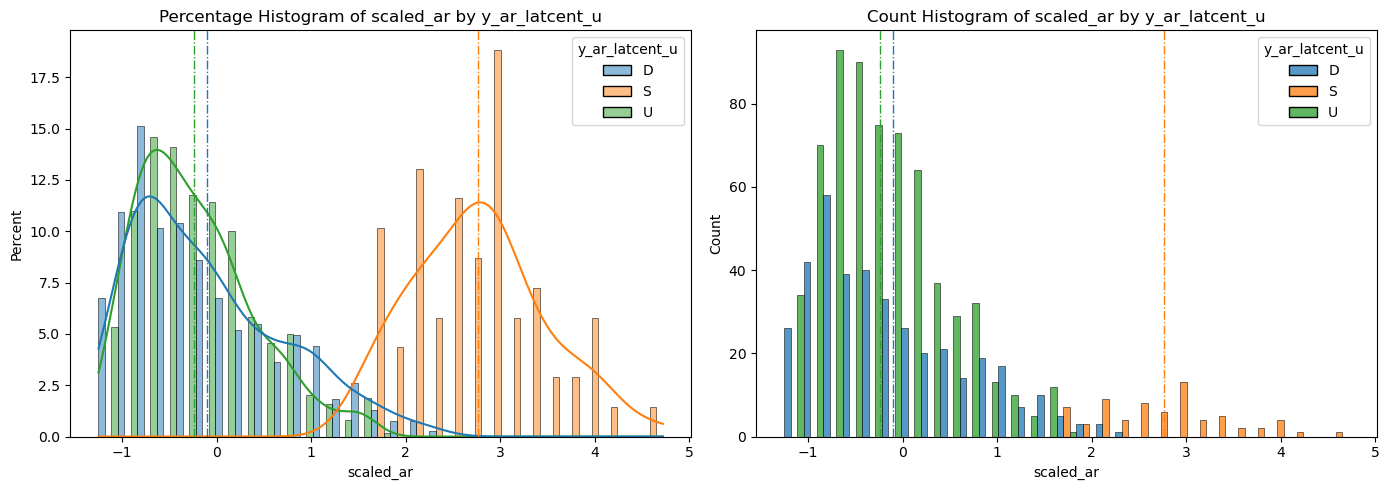

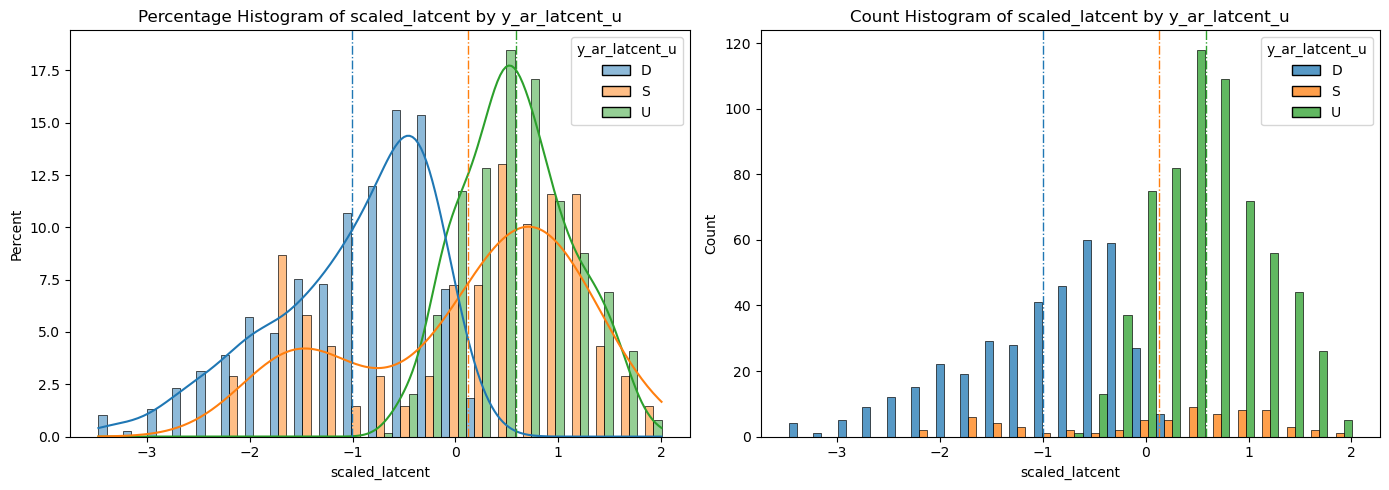

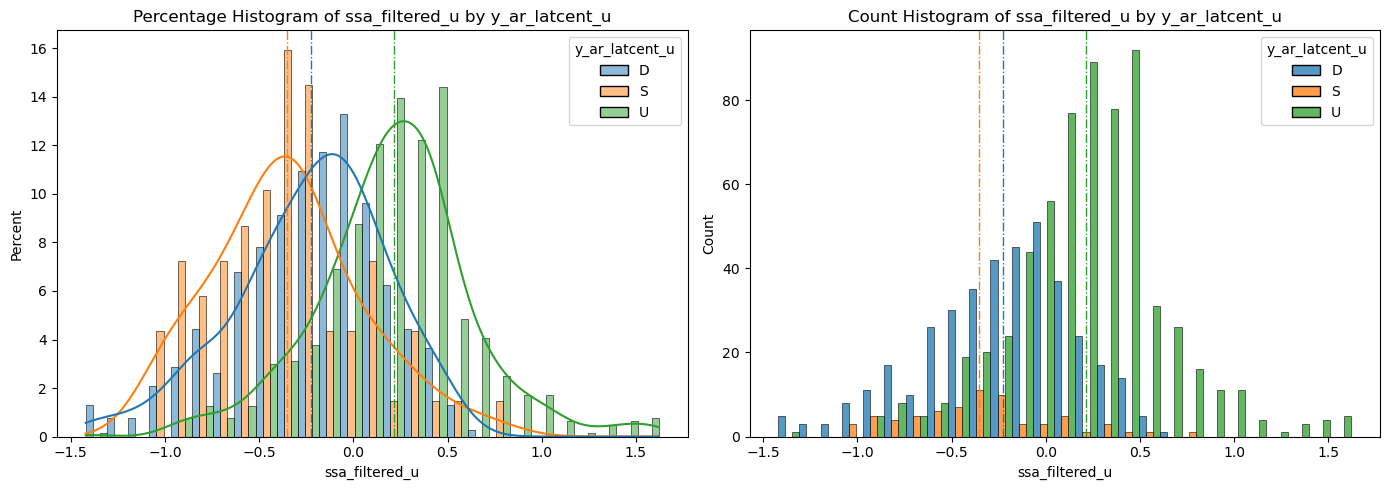

In [27]:
demo['y_ar_latcent_u'] = demo['y_ar_latcent_u'].replace({0:'S', 1:'D', 2:'U'})
print("Averages per class and features:")
print(demo[['y_ar_latcent_u', 'scaled_ar', 'scaled_latcent', 'ssa_filtered_u']].groupby(['y_ar_latcent_u']).mean())
print(demo['y_ar_latcent_u'].value_counts())
plot_hist_per_class(demo, # data
                    features_kopt[3], # information about used feature and k_opt
                    'y_ar_latcent_u') # column name with y values


### Aspect ratio, latcent and vortex area
Adding the area computed with at 10hPa geopotential height, added some ambiguity to the interpretation as split, displaced and undisturbed.

The unfiltered area seems to be the key feature to separate clusters. The majority of the samples is contained by class **0**, whereas class **1** and **2** contain samples with large areas. The distribution of the aspect ratio is roughly the same for both classes, though slightly below average. This indicates particularly round vortices. Class **1** and **2** are differentiated by the centroid latitude, which exhibits smaller values for class **1**. Respectively, the classes are interpreted as large, displaced vortices (Ld) and large, centered vortices (Lc).

For the unfiltered area:<br>
**0** &rarr; U (Undisturbed)<br>
**1** &rarr; Ld (Large displaced)<br>
**2** &rarr; Lc (Large centered)

When the area is filtered class **2** has the largest aspect ratio compared to class **0** and **1**. Class **0** contains most samples and does not exhibit any remarkable characteristics. Again, the notion of a displaced clusters seems not accurate to describe the characteristics of class **1**, as it shows clearly larger area values than the other two clusters. Consquently, the clusters are interpreted as:

For the scaled area:<br>
**0** &rarr; U (Undisturbed)<br>
**1** &rarr; L (Large)<br>
**2** &rarr; S (Split)

Averages per class and features:
                     scaled_ar  scaled_latcent  scaled_area
y_ar_latcent_scArea                                        
Lc                   -1.062876       -1.293905     5.165408
Ld                   -0.991041        0.596336     6.608523
U                     0.019920        0.000662    -0.120259
y_ar_latcent_scArea
U     1070
Ld      14
Lc       7
Name: count, dtype: int64


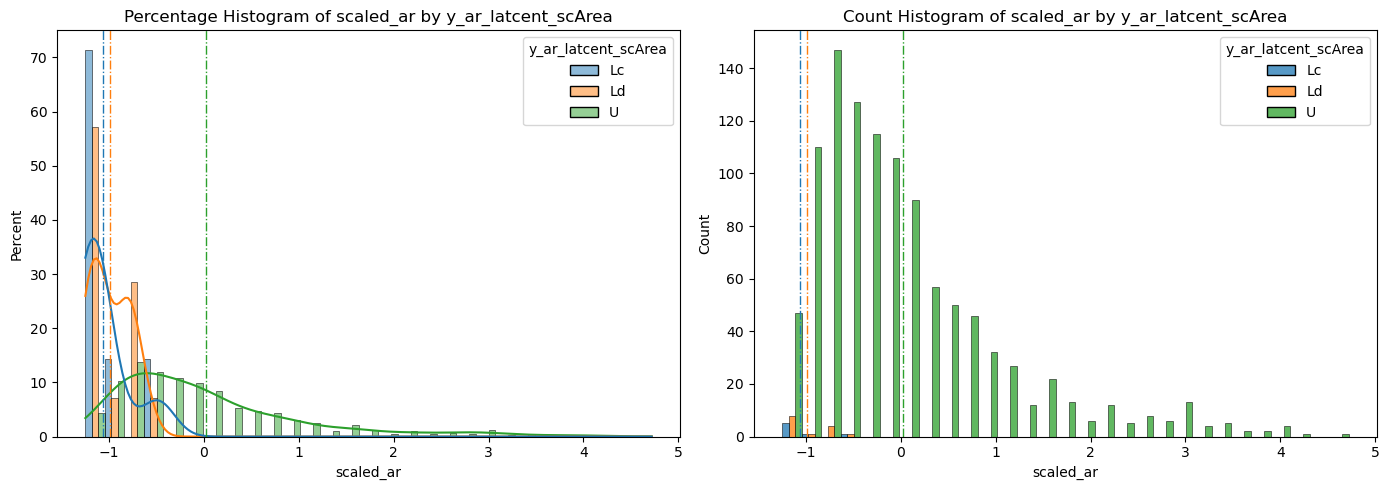

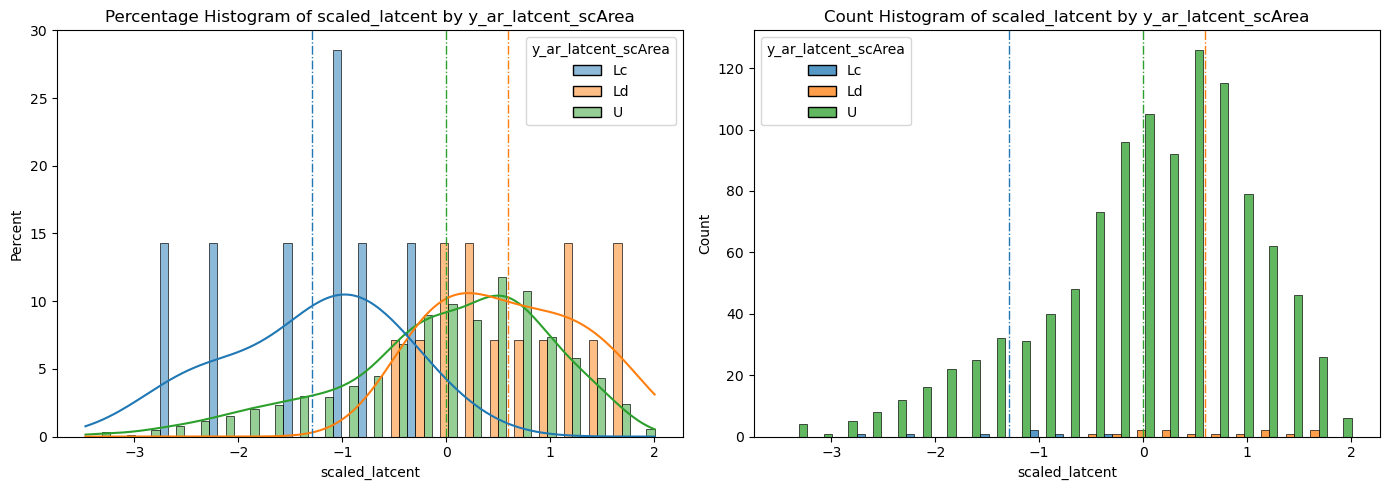

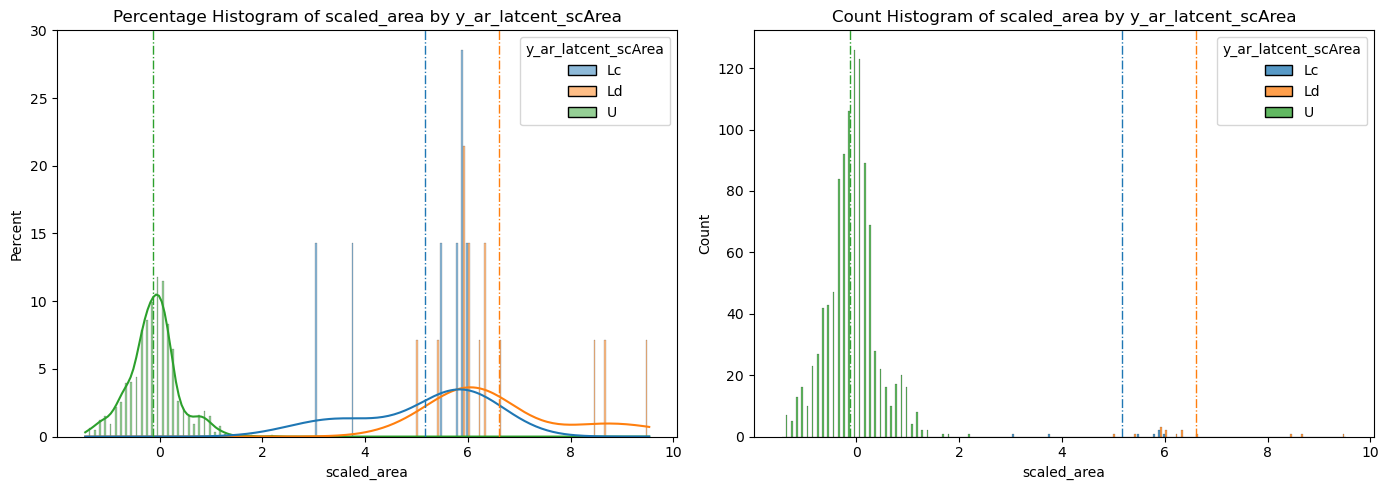

Averages per class and features:
                           scaled_ar  scaled_latcent  ssa_filtered_area
y_ar_latcent_filteredArea                                              
L                          -1.041202        0.093254           3.841518
S                           2.351219        0.324278           0.037878
U                          -0.218052       -0.034947          -0.087164
y_ar_latcent_filteredArea
U    972
S     99
L     20
Name: count, dtype: int64


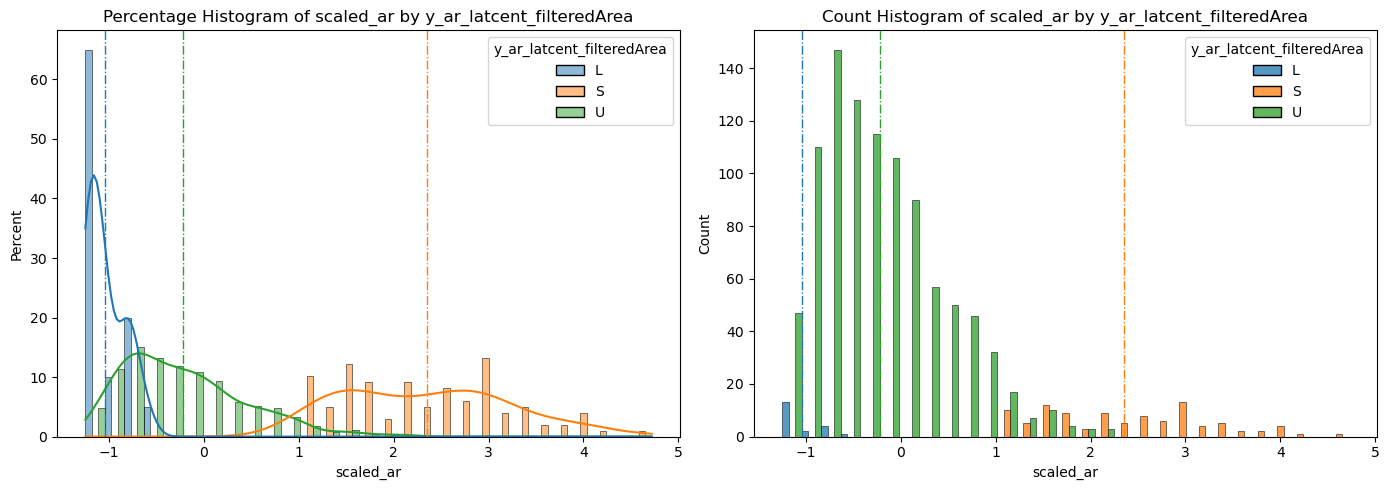

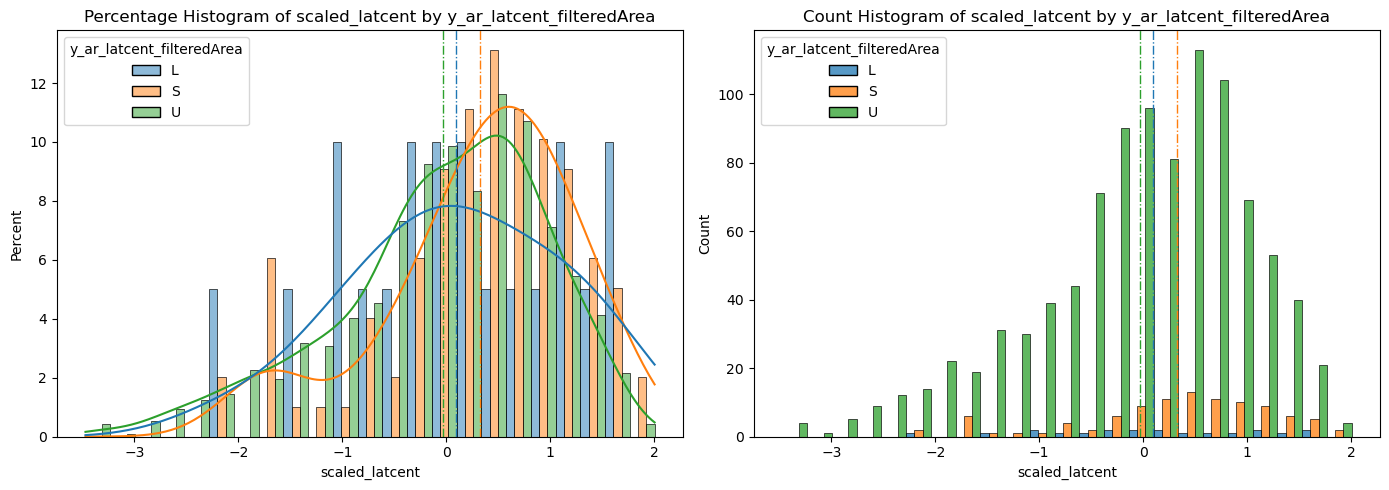

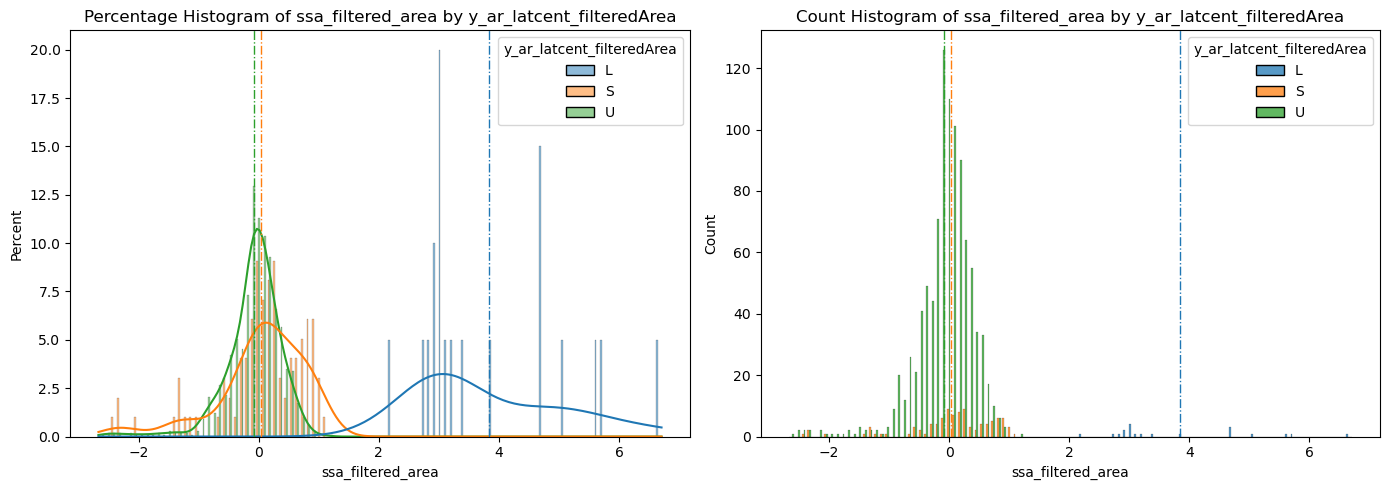

In [34]:
demo['y_ar_latcent_scArea'] = demo['y_ar_latcent_scArea'].replace({0: 'U', 1:'Ld', 2:'Lc'})
demo['y_ar_latcent_filteredArea'] = demo['y_ar_latcent_filteredArea'].replace({0: 'U', 1:'L', 2:'S'})

print("Averages per class and features:")
print(demo[['y_ar_latcent_scArea', 'scaled_ar', 'scaled_latcent', 'scaled_area']].groupby(['y_ar_latcent_scArea']).mean())
print(demo['y_ar_latcent_scArea'].value_counts())

plot_hist_per_class(demo, # data
                    features_kopt[1], # information about used feature and k_opt
                    'y_ar_latcent_scArea') # column name with y values

print("Averages per class and features:")
print(demo[['y_ar_latcent_filteredArea', 'scaled_ar', 'scaled_latcent', 'ssa_filtered_area']].groupby(['y_ar_latcent_filteredArea']).mean())
print(demo['y_ar_latcent_filteredArea'].value_counts())

plot_hist_per_class(demo, # data
                    features_kopt[2], # information about used feature and k_opt
                    'y_ar_latcent_filteredArea') # column name with y values

## Physical interpretation and Literature Comparison

The following table illustrates the distribution of classes in H11:

<table>
  <tr>
    <th></th>
    <th colspan="4">AR, Latcent and filtered Area</th>
  </tr>
  <tr>
    <th>AR, Latcent</th>
    <th>D (0) </th>
    <th>U (2) </th>
    <th>S (1) </th>
    <th>Total</th>
  </tr>
  <tr>
    <th>D (2) </th>
    <td>7</td>
    <td>3</td>
    <td>0</td>
    <td>10</td>
  </tr>
  <tr>
    <th>U (1)</th>
    <td>4</td>
    <td>80</td>
    <td>2</td>
    <td>86</td>
  </tr>
  <tr>
    <th>S (0)</th>
    <td>1</td>
    <td>0</td>
    <td>3</td>
    <td>4</td>
  </tr>
  <tr>
    <th>Total</th>
    <td>12</td>
    <td>83</td>
    <td>5</td>
    <td>100</td>
  </tr>
</table>
The classification using the demo data deviates notably from H11, as shown by the following pivot table (% of total).


Several factors likely explain this divergence:
- The dataset is truncated to 1000 days, limiting event diversity.
- Only a handful of major warmings and displacements occur in this short period.
- According to Soci et al. (2024), the demo data is statistically extracted, and lacks full dynamical richness.

In [35]:
pd.pivot_table(data=demo[['y_ar_latcent', 'string','y_ar_latcent_u']], index='y_ar_latcent', columns='y_ar_latcent_u', aggfunc = 'count', margins=True)/demo.shape[0]*100

string                                 
y_ar_latcent_u          D         S          U         All
y_ar_latcent                                              
D               35.105408  1.649863  22.181485   58.936755
S                     NaN  3.758020        NaN    3.758020
U                0.091659  0.916590  36.296975   37.305225
All             35.197067  6.324473  58.478460  100.000000

Based on the aspect ratio a differentiation between split and displaced was computed. This computation is part of the elliptical indices and everything is either marked as split or displaced. 3 of the 4 models reliably recognize the majority of the events marked as split with respect to the aspect ratio.

To compare the classification by the hierarchical models to the computed split and displaced classification, the measures of accuracy (acc), precision, recall and f1 score are introduced. They base on the notion of true positive (TP), i.e. an even is clustered and computed as split, true negative (TN), i.e. an event is not clustered as split and not computed as such, false positive (FP), i.e. an event is clustered as split, but not computed as split, and false negative (FN), i.e. an event is marked as not split, but was computed as split. The four measurements are calculated as follows:
$$
acc = \frac{TN+TP}{TP+TN+FP+FN}
$$
$$
precision = \frac{TP}{TP+FP}
$$
$$
recall = \frac{TP}{TP+FN}
$$
$$
f1 = \frac{2*precision*recall}{precision+recall}
$$

For each 1 is best and 0 is worst. With respect to form, the model including the wind speed performs better than the other models as can be seen by its very high accuracy (0.98) and its high precision (0.78) and recall (0.85) values. Though the model based on ar and latcent manages to retrieve most computed split events and performes better than in the full analysis. On the other hand, it severely overestimates displaced events and includes a lot of false positives.

In [39]:
from vortexclust.workflows.demo import compare_cluster

compare_cluster(demo.merge(demo_all[['string', 'form']], on='string', how='inner'), compare_col='form',
                pred_value='S', gt_value=1, y_names=['y_ar_latcent', 'y_ar_latcent_filteredArea', 'y_ar_latcent_u'])
compare_cluster(demo.merge(demo_all[['string', 'form']], on='string', how='inner'), compare_col='form', pred_value='U', gt_value=0, y_names=['y_ar_latcent_scArea'])

----------------------------------------------
Comparison of Percentages:  y_ar_latcent (predicted: S) vs form (ground truth: 1)
y_ar_latcent      D     S      U     All
form                                    
0             57.29  0.18  37.21   94.68
1              1.65  3.57   0.09    5.32
All           58.94  3.76  37.31  100.00
Accuracy: 0.98
Precision: 0.95
Recall: 0.67
F1 Score: 0.79
----------------------------------------------
Comparison of Percentages:  y_ar_latcent_filteredArea (predicted: S) vs form (ground truth: 1)
y_ar_latcent_filteredArea     L     S      U     All
form                                                
0                          1.83  3.85  89.00   94.68
1                          0.00  5.22   0.09    5.32
All                        1.83  9.07  89.09  100.00
Accuracy: 0.96
Precision: 0.58
Recall: 0.98
F1 Score: 0.73
----------------------------------------------
Comparison of Percentages:  y_ar_latcent_u (predicted: S) vs form (ground truth: 1)
y_ar_latce

Seviour et al. (2013) presented a threshold based method to distinguish between split and displaced events. A displaced event is defined as:

> Displaced events are identified if the centroid latitude remains equatorward 66ıN for 7 days or more.7

And a split event as:
> Split events are identified if the aspect ratio remains above 2.4 for 7 days or more.

To avoid overlapping detections, no two events may occur within 30 days. If they do, the first occurrence determines the classification.

Key results:

| Feature Set                          | Accuracy | Precision | Recall   | F1 Score |
|--------------------------------------|----------|-----------|----------|----------|
| **AR, Latcent**                      | 0.97     | 0.59      | 0.59     | 0.59     |
| **AR, Latcent, Filtered Area**       | 0.94     | 0.36      | 0.88     | 0.51     |
| **AR, Latcent, Filtered Wind Speed** | 0.97     | 0.54      | 0.9      | 0.67     |

Among these, the model based on `y_ar_latcent_u` (which includes filtered wind speed) provides the best balance between precision and recall. Notably, the model using `scaled_area` was excluded, as its interpretation does not align clearly with the binary split/displaced classification used in Seviour et al. (2013).



In [41]:
labels = vortexclust.split_displaced_seviour(demo[['ar', 'latcent', 'string']])
demo['seviour'] = labels

compare_cluster(demo, compare_col = 'seviour', pred_value = 'S', gt_value='split', y_names=['y_ar_latcent', 'y_ar_latcent_filteredArea', 'y_ar_latcent_u'])

----------------------------------------------
Comparison of Percentages:  y_ar_latcent (predicted: S) vs seviour (ground truth: split)
y_ar_latcent      D     S      U     All
seviour                                 
split          1.56  2.20   0.00    3.76
undisturbed   57.38  1.56  37.31   96.24
All           58.94  3.76  37.31  100.00
Accuracy: 0.97
Precision: 0.59
Recall: 0.59
F1 Score: 0.59
----------------------------------------------
Comparison of Percentages:  y_ar_latcent_filteredArea (predicted: S) vs seviour (ground truth: split)
y_ar_latcent_filteredArea     L     S      U     All
seviour                                             
split                      0.00  3.30   0.46    3.76
undisturbed                1.83  5.77  88.63   96.24
All                        1.83  9.07  89.09  100.00
Accuracy: 0.94
Precision: 0.36
Recall: 0.88
F1 Score: 0.51
----------------------------------------------
Comparison of Percentages:  y_ar_latcent_u (predicted: S) vs seviour (ground tru

# Abbreviations

|          |                                                 |
|---------:|:------------------------------------------------|
|      H11 | Hannachi et al. 2011                            |
|      IAP | Institute for Atmospheric Physics Kühlungsborn  |
|     DJFM | December, January, February, March              |
|       ar | Aspect ratio                                    |
|  latcent | centroid latitude                               |
|      SSW | Sudden Stratospheric Warming                    |
|        S | Cluster of split vortices                       |
|        D | Cluster of displaced vortices                   |
|        L | Cluster of large vortices                       |
|        U | Cluster of undisturbed vortices                 |
|      ACF | Autocorrelation function                        |
|     PACF | Partial Autocorrelation function                |